In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
from time import time
import logging
import nltk, re, string, time, glob,os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn import utils
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import gensim
from tqdm import tqdm
from bs4 import BeautifulSoup
import pygtrie
import dask.dataframe as dd
import dask.distributed
import heapq
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


INFO - 12:00:27: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 12:00:27: built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [3]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "IRAhandle_tweets_*.csv"))))
df.head()

C:\Users\Rajnish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Rajnish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Rajnish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (0,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [4]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.add('"')
stop_words.add('\\')
global regex 
porter = PorterStemmer()
regex = re.compile('[%s]' % re.escape(string.punctuation[0:2] + string.punctuation[3:]))
def cleanText(text):
    text = str(text)
    text = re.sub(r'http\S+', r' ', text)
    text = regex.sub('', text)
    text = text.lower()
    sentence = ''
    for word in text.split(' '):
        if word not in stop_words:
            sentence += porter.stem(word) + ' '
    text = sentence
    return text

In [5]:
df_new=df[df['language']=='English']
df_new['content']=df_new['content'].apply(cleanText)


C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:

tagged_data = [TaggedDocument(words=_d.split(' '), tags=[str(df_new.iloc[i]['tweet_id']),df_new.iloc[i]['account_type']]) for i, _d in enumerate(df_new['content'])]


max_epochs = 20
vec_size = 20
alpha = 0.025

t = time()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=7, progress_per=10000)
model_dbow.build_vocab([x for x in tqdm(tagged_data)])

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

100%|███████████████████████████████████████████████████████████████████| 2116867/2116867 [00:00<00:00, 2622944.07it/s]
INFO - 17:19:35: collecting all words and their counts
INFO - 17:19:35: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO - 17:19:35: PROGRESS: at example #10000, processed 105631 words (533805/s), 14696 word types, 10008 tags
INFO - 17:19:35: PROGRESS: at example #20000, processed 227214 words (339485/s), 25919 word types, 20008 tags
INFO - 17:19:37: PROGRESS: at example #30000, processed 348748 words (54694/s), 29809 word types, 30008 tags
INFO - 17:19:38: PROGRESS: at example #40000, processed 463146 words (220302/s), 35618 word types, 40010 tags
INFO - 17:19:38: PROGRESS: at example #50000, processed 585006 words (732696/s), 43585 word types, 50010 tags
INFO - 17:19:38: PROGRESS: at example #60000, processed 717313 words (637804/s), 51182 word types, 60010 tags
INFO - 17:19:38: PROGRESS: at example #70000, processed 831160 words (817391/s

INFO - 17:19:44: PROGRESS: at example #710000, processed 8275800 words (1588185/s), 225256 word types, 710015 tags
INFO - 17:19:44: PROGRESS: at example #720000, processed 8355263 words (1204050/s), 226362 word types, 720015 tags
INFO - 17:19:44: PROGRESS: at example #730000, processed 8437166 words (1287404/s), 227380 word types, 730015 tags
INFO - 17:19:44: PROGRESS: at example #740000, processed 8552355 words (1475127/s), 231054 word types, 740015 tags
INFO - 17:19:44: PROGRESS: at example #750000, processed 8666799 words (1717367/s), 233293 word types, 750015 tags
INFO - 17:19:44: PROGRESS: at example #760000, processed 8780571 words (1930881/s), 234160 word types, 760015 tags
INFO - 17:19:44: PROGRESS: at example #770000, processed 8903772 words (1799379/s), 237439 word types, 770015 tags
INFO - 17:19:44: PROGRESS: at example #780000, processed 9019698 words (1882141/s), 238460 word types, 780015 tags
INFO - 17:19:44: PROGRESS: at example #790000, processed 9145371 words (1835014/

INFO - 17:19:49: PROGRESS: at example #1420000, processed 16585554 words (1348410/s), 640162 word types, 1420016 tags
INFO - 17:19:49: PROGRESS: at example #1430000, processed 16715312 words (1707697/s), 670446 word types, 1430016 tags
INFO - 17:19:49: PROGRESS: at example #1440000, processed 16848917 words (1106737/s), 712795 word types, 1440016 tags
INFO - 17:19:49: PROGRESS: at example #1450000, processed 16985698 words (1520748/s), 749520 word types, 1450016 tags
INFO - 17:19:49: PROGRESS: at example #1460000, processed 17112769 words (1757065/s), 768172 word types, 1460016 tags
INFO - 17:19:49: PROGRESS: at example #1470000, processed 17245680 words (1758291/s), 812594 word types, 1470016 tags
INFO - 17:19:49: PROGRESS: at example #1480000, processed 17362874 words (1558526/s), 841654 word types, 1480016 tags
INFO - 17:19:49: PROGRESS: at example #1490000, processed 17479694 words (1811907/s), 843587 word types, 1490016 tags
INFO - 17:19:49: PROGRESS: at example #1500000, processe

INFO - 17:19:53: collected 946513 word types and 2115499 unique tags from a corpus of 2116867 examples and 24724790 words
INFO - 17:19:53: Loading a fresh vocabulary
INFO - 17:20:41: effective_min_count=2 retains 286198 unique words (30% of original 946513, drops 660315)
INFO - 17:20:41: effective_min_count=2 leaves 24064475 word corpus (97% of original 24724790, drops 660315)
INFO - 17:20:42: deleting the raw counts dictionary of 946513 items
INFO - 17:20:42: sample=0 downsamples 0 most-common words
INFO - 17:20:42: downsampling leaves estimated 24064475 word corpus (100.0% of prior 24064475)
INFO - 17:20:43: estimated required memory for 286198 words and 300 dimensions: 3791672800 bytes
INFO - 17:20:43: resetting layer weights


Time to build vocab: 1.91 mins


In [62]:
t=time()

#for epoch in range(30):
model_dbow.train(utils.shuffle([x for x in tqdm(tagged_data)]), total_examples=len(tagged_data), epochs=30)
model_dbow.alpha -= 0.002
model_dbow.min_alpha = model_dbow.alpha

print('Time to train: {} mins'.format(round((time() - t) / 60, 2)))

100%|███████████████████████████████████████████████████████████████████| 2116867/2116867 [00:00<00:00, 2589967.38it/s]
INFO - 17:21:30: training model with 7 workers on 286198 vocabulary and 300 features, using sg=1 hs=0 sample=0 negative=5 window=5
INFO - 17:21:35: EPOCH 1 - PROGRESS: at 0.04% examples, 2210 words/s, in_qsize 14, out_qsize 0
INFO - 17:21:38: EPOCH 1 - PROGRESS: at 0.32% examples, 11120 words/s, in_qsize 13, out_qsize 0
INFO - 17:21:40: EPOCH 1 - PROGRESS: at 0.57% examples, 16105 words/s, in_qsize 13, out_qsize 0
INFO - 17:21:41: EPOCH 1 - PROGRESS: at 0.69% examples, 17565 words/s, in_qsize 14, out_qsize 0
INFO - 17:21:43: EPOCH 1 - PROGRESS: at 0.85% examples, 19112 words/s, in_qsize 14, out_qsize 0
INFO - 17:21:45: EPOCH 1 - PROGRESS: at 1.13% examples, 21858 words/s, in_qsize 13, out_qsize 0
INFO - 17:21:46: EPOCH 1 - PROGRESS: at 1.42% examples, 24846 words/s, in_qsize 14, out_qsize 0
INFO - 17:21:47: EPOCH 1 - PROGRESS: at 1.70% examples, 27543 words/s, in_qsiz

INFO - 17:23:09: EPOCH 1 - PROGRESS: at 49.02% examples, 140516 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:10: EPOCH 1 - PROGRESS: at 50.16% examples, 142248 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:11: EPOCH 1 - PROGRESS: at 51.29% examples, 143990 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:12: EPOCH 1 - PROGRESS: at 52.42% examples, 145714 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:13: EPOCH 1 - PROGRESS: at 53.55% examples, 147372 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:14: EPOCH 1 - PROGRESS: at 54.76% examples, 149221 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:15: EPOCH 1 - PROGRESS: at 55.90% examples, 150814 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:16: EPOCH 1 - PROGRESS: at 56.87% examples, 151956 words/s, in_qsize 13, out_qsize 0
INFO - 17:23:17: EPOCH 1 - PROGRESS: at 57.83% examples, 153096 words/s, in_qsize 14, out_qsize 0
INFO - 17:23:18: EPOCH 1 - PROGRESS: at 58.76% examples, 154112 words/s, in_qsize 13, out_qsize 0
INFO - 17:23:19: EPO

INFO - 17:24:32: EPOCH 2 - PROGRESS: at 18.51% examples, 196716 words/s, in_qsize 13, out_qsize 0
INFO - 17:24:33: EPOCH 2 - PROGRESS: at 19.36% examples, 198010 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:34: EPOCH 2 - PROGRESS: at 20.29% examples, 200143 words/s, in_qsize 13, out_qsize 0
INFO - 17:24:35: EPOCH 2 - PROGRESS: at 20.81% examples, 193431 words/s, in_qsize 13, out_qsize 0
INFO - 17:24:39: EPOCH 2 - PROGRESS: at 20.89% examples, 175126 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:40: EPOCH 2 - PROGRESS: at 21.66% examples, 176209 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:41: EPOCH 2 - PROGRESS: at 22.59% examples, 178579 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:42: EPOCH 2 - PROGRESS: at 23.64% examples, 181625 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:43: EPOCH 2 - PROGRESS: at 24.61% examples, 183759 words/s, in_qsize 13, out_qsize 0
INFO - 17:24:44: EPOCH 2 - PROGRESS: at 25.50% examples, 185488 words/s, in_qsize 14, out_qsize 0
INFO - 17:24:45: EPO

INFO - 17:26:06: EPOCH 2 - PROGRESS: at 87.78% examples, 204834 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:07: EPOCH 2 - PROGRESS: at 88.23% examples, 204053 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:08: EPOCH 2 - PROGRESS: at 88.67% examples, 203363 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:09: EPOCH 2 - PROGRESS: at 89.53% examples, 203554 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:11: EPOCH 2 - PROGRESS: at 89.93% examples, 202610 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:12: EPOCH 2 - PROGRESS: at 90.94% examples, 203198 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:13: EPOCH 2 - PROGRESS: at 91.87% examples, 203652 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:14: EPOCH 2 - PROGRESS: at 92.60% examples, 203257 words/s, in_qsize 13, out_qsize 0
INFO - 17:26:15: EPOCH 2 - PROGRESS: at 93.53% examples, 203574 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:16: EPOCH 2 - PROGRESS: at 94.38% examples, 203838 words/s, in_qsize 14, out_qsize 0
INFO - 17:26:17: EPO

INFO - 17:27:33: EPOCH 3 - PROGRESS: at 50.03% examples, 204300 words/s, in_qsize 13, out_qsize 0
INFO - 17:27:34: EPOCH 3 - PROGRESS: at 50.93% examples, 204855 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:35: EPOCH 3 - PROGRESS: at 51.81% examples, 205467 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:36: EPOCH 3 - PROGRESS: at 52.74% examples, 206157 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:37: EPOCH 3 - PROGRESS: at 53.15% examples, 204191 words/s, in_qsize 13, out_qsize 0
INFO - 17:27:38: EPOCH 3 - PROGRESS: at 54.04% examples, 204703 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:39: EPOCH 3 - PROGRESS: at 55.05% examples, 205712 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:41: EPOCH 3 - PROGRESS: at 55.70% examples, 205407 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:42: EPOCH 3 - PROGRESS: at 56.22% examples, 204661 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:43: EPOCH 3 - PROGRESS: at 57.31% examples, 205703 words/s, in_qsize 14, out_qsize 0
INFO - 17:27:44: EPO

INFO - 17:28:58: EPOCH 4 - PROGRESS: at 16.09% examples, 234356 words/s, in_qsize 14, out_qsize 0
INFO - 17:28:59: EPOCH 4 - PROGRESS: at 16.17% examples, 223545 words/s, in_qsize 13, out_qsize 0
INFO - 17:29:00: EPOCH 4 - PROGRESS: at 16.86% examples, 222086 words/s, in_qsize 14, out_qsize 0
INFO - 17:29:01: EPOCH 4 - PROGRESS: at 17.91% examples, 224988 words/s, in_qsize 14, out_qsize 0
INFO - 17:29:02: EPOCH 4 - PROGRESS: at 19.00% examples, 228527 words/s, in_qsize 13, out_qsize 0
INFO - 17:29:04: EPOCH 4 - PROGRESS: at 20.04% examples, 231043 words/s, in_qsize 13, out_qsize 0
INFO - 17:29:05: EPOCH 4 - PROGRESS: at 20.93% examples, 231591 words/s, in_qsize 13, out_qsize 0
INFO - 17:29:06: EPOCH 4 - PROGRESS: at 21.54% examples, 228901 words/s, in_qsize 14, out_qsize 0
INFO - 17:29:07: EPOCH 4 - PROGRESS: at 22.59% examples, 230978 words/s, in_qsize 13, out_qsize 0
INFO - 17:29:08: EPOCH 4 - PROGRESS: at 23.16% examples, 228347 words/s, in_qsize 14, out_qsize 0
INFO - 17:29:09: EPO

INFO - 17:30:28: EPOCH 4 - PROGRESS: at 95.02% examples, 245656 words/s, in_qsize 14, out_qsize 0
INFO - 17:30:29: EPOCH 4 - PROGRESS: at 96.11% examples, 246108 words/s, in_qsize 14, out_qsize 0
INFO - 17:30:31: EPOCH 4 - PROGRESS: at 97.25% examples, 246644 words/s, in_qsize 14, out_qsize 0
INFO - 17:30:32: EPOCH 4 - PROGRESS: at 98.10% examples, 246439 words/s, in_qsize 14, out_qsize 0
INFO - 17:30:33: EPOCH 4 - PROGRESS: at 99.31% examples, 247234 words/s, in_qsize 13, out_qsize 0
INFO - 17:30:33: worker thread finished; awaiting finish of 6 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 5 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 4 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 3 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 2 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 1 more threads
INFO - 17:30:33: worker thread finished; awaiting finish of 

INFO - 17:31:53: EPOCH 5 - PROGRESS: at 73.39% examples, 261616 words/s, in_qsize 13, out_qsize 0
INFO - 17:31:54: EPOCH 5 - PROGRESS: at 73.48% examples, 257126 words/s, in_qsize 13, out_qsize 0
INFO - 17:31:55: EPOCH 5 - PROGRESS: at 73.96% examples, 255617 words/s, in_qsize 14, out_qsize 0
INFO - 17:31:56: EPOCH 5 - PROGRESS: at 75.01% examples, 256060 words/s, in_qsize 13, out_qsize 0
INFO - 17:31:57: EPOCH 5 - PROGRESS: at 75.95% examples, 256077 words/s, in_qsize 14, out_qsize 0
INFO - 17:31:58: EPOCH 5 - PROGRESS: at 76.84% examples, 256008 words/s, in_qsize 14, out_qsize 0
INFO - 17:31:59: EPOCH 5 - PROGRESS: at 77.76% examples, 255981 words/s, in_qsize 13, out_qsize 0
INFO - 17:32:00: EPOCH 5 - PROGRESS: at 78.73% examples, 256172 words/s, in_qsize 14, out_qsize 0
INFO - 17:32:01: EPOCH 5 - PROGRESS: at 79.62% examples, 255441 words/s, in_qsize 13, out_qsize 0
INFO - 17:32:03: EPOCH 5 - PROGRESS: at 80.39% examples, 254482 words/s, in_qsize 14, out_qsize 0
INFO - 17:32:04: EPO

INFO - 17:33:15: EPOCH 6 - PROGRESS: at 50.28% examples, 271478 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:16: EPOCH 6 - PROGRESS: at 51.45% examples, 272464 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:17: EPOCH 6 - PROGRESS: at 52.58% examples, 273313 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:18: EPOCH 6 - PROGRESS: at 53.71% examples, 273839 words/s, in_qsize 13, out_qsize 0
INFO - 17:33:19: EPOCH 6 - PROGRESS: at 54.60% examples, 273367 words/s, in_qsize 13, out_qsize 0
INFO - 17:33:20: EPOCH 6 - PROGRESS: at 54.85% examples, 268207 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:21: EPOCH 6 - PROGRESS: at 55.13% examples, 264993 words/s, in_qsize 13, out_qsize 0
INFO - 17:33:22: EPOCH 6 - PROGRESS: at 56.34% examples, 266284 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:23: EPOCH 6 - PROGRESS: at 57.51% examples, 267274 words/s, in_qsize 13, out_qsize 0
INFO - 17:33:24: EPOCH 6 - PROGRESS: at 58.64% examples, 268036 words/s, in_qsize 14, out_qsize 0
INFO - 17:33:25: EPO

INFO - 17:34:38: EPOCH 7 - PROGRESS: at 31.89% examples, 295874 words/s, in_qsize 13, out_qsize 0
INFO - 17:34:39: EPOCH 7 - PROGRESS: at 33.10% examples, 297230 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:40: EPOCH 7 - PROGRESS: at 34.27% examples, 298010 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:41: EPOCH 7 - PROGRESS: at 35.24% examples, 297245 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:42: EPOCH 7 - PROGRESS: at 36.29% examples, 296397 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:43: EPOCH 7 - PROGRESS: at 37.42% examples, 296731 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:44: EPOCH 7 - PROGRESS: at 38.56% examples, 297359 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:45: EPOCH 7 - PROGRESS: at 39.69% examples, 297726 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:46: EPOCH 7 - PROGRESS: at 40.82% examples, 297964 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:47: EPOCH 7 - PROGRESS: at 41.95% examples, 298147 words/s, in_qsize 14, out_qsize 0
INFO - 17:34:48: EPO

INFO - 17:35:59: EPOCH 8 - PROGRESS: at 26.87% examples, 350378 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:00: EPOCH 8 - PROGRESS: at 28.17% examples, 350335 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:01: EPOCH 8 - PROGRESS: at 29.46% examples, 350532 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:03: EPOCH 8 - PROGRESS: at 30.76% examples, 350344 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:04: EPOCH 8 - PROGRESS: at 32.09% examples, 350546 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:05: EPOCH 8 - PROGRESS: at 33.42% examples, 351136 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:06: EPOCH 8 - PROGRESS: at 34.72% examples, 351223 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:07: EPOCH 8 - PROGRESS: at 36.05% examples, 351189 words/s, in_qsize 13, out_qsize 0
INFO - 17:36:08: EPOCH 8 - PROGRESS: at 37.38% examples, 352014 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:09: EPOCH 8 - PROGRESS: at 38.60% examples, 351378 words/s, in_qsize 14, out_qsize 0
INFO - 17:36:10: EPO

INFO - 17:37:21: EPOCH 9 - PROGRESS: at 29.34% examples, 356698 words/s, in_qsize 13, out_qsize 0
INFO - 17:37:22: EPOCH 9 - PROGRESS: at 30.35% examples, 353660 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:23: EPOCH 9 - PROGRESS: at 31.56% examples, 352929 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:24: EPOCH 9 - PROGRESS: at 32.74% examples, 351860 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:25: EPOCH 9 - PROGRESS: at 33.99% examples, 351236 words/s, in_qsize 13, out_qsize 0
INFO - 17:37:26: EPOCH 9 - PROGRESS: at 35.24% examples, 351339 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:27: EPOCH 9 - PROGRESS: at 36.58% examples, 351193 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:28: EPOCH 9 - PROGRESS: at 37.83% examples, 351226 words/s, in_qsize 13, out_qsize 0
INFO - 17:37:29: EPOCH 9 - PROGRESS: at 38.84% examples, 349111 words/s, in_qsize 13, out_qsize 0
INFO - 17:37:30: EPOCH 9 - PROGRESS: at 40.13% examples, 349630 words/s, in_qsize 14, out_qsize 0
INFO - 17:37:31: EPO

INFO - 17:38:40: EPOCH 10 - PROGRESS: at 28.13% examples, 350024 words/s, in_qsize 13, out_qsize 0
INFO - 17:38:41: EPOCH 10 - PROGRESS: at 29.34% examples, 349705 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:42: EPOCH 10 - PROGRESS: at 30.68% examples, 350529 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:43: EPOCH 10 - PROGRESS: at 31.84% examples, 349615 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:44: EPOCH 10 - PROGRESS: at 33.18% examples, 350419 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:45: EPOCH 10 - PROGRESS: at 34.43% examples, 350410 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:46: EPOCH 10 - PROGRESS: at 35.81% examples, 350740 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:47: EPOCH 10 - PROGRESS: at 37.14% examples, 351326 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:48: EPOCH 10 - PROGRESS: at 38.36% examples, 351045 words/s, in_qsize 14, out_qsize 0
INFO - 17:38:49: EPOCH 10 - PROGRESS: at 39.61% examples, 351132 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:40:00: EPOCH 11 - PROGRESS: at 28.94% examples, 353269 words/s, in_qsize 14, out_qsize 0
INFO - 17:40:02: EPOCH 11 - PROGRESS: at 30.35% examples, 353968 words/s, in_qsize 13, out_qsize 0
INFO - 17:40:03: EPOCH 11 - PROGRESS: at 31.72% examples, 354933 words/s, in_qsize 14, out_qsize 0
INFO - 17:40:04: EPOCH 11 - PROGRESS: at 32.90% examples, 353386 words/s, in_qsize 14, out_qsize 0
INFO - 17:40:05: EPOCH 11 - PROGRESS: at 34.31% examples, 353943 words/s, in_qsize 13, out_qsize 0
INFO - 17:40:06: EPOCH 11 - PROGRESS: at 35.69% examples, 355039 words/s, in_qsize 14, out_qsize 0
INFO - 17:40:07: EPOCH 11 - PROGRESS: at 37.10% examples, 355829 words/s, in_qsize 13, out_qsize 0
INFO - 17:40:08: EPOCH 11 - PROGRESS: at 38.48% examples, 356890 words/s, in_qsize 14, out_qsize 0
INFO - 17:40:09: EPOCH 11 - PROGRESS: at 39.69% examples, 356329 words/s, in_qsize 13, out_qsize 0
INFO - 17:40:10: EPOCH 11 - PROGRESS: at 41.10% examples, 357153 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:41:21: EPOCH 12 - PROGRESS: at 28.33% examples, 334156 words/s, in_qsize 13, out_qsize 0
INFO - 17:41:22: EPOCH 12 - PROGRESS: at 29.62% examples, 335367 words/s, in_qsize 13, out_qsize 0
INFO - 17:41:23: EPOCH 12 - PROGRESS: at 30.88% examples, 335338 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:24: EPOCH 12 - PROGRESS: at 32.29% examples, 336324 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:25: EPOCH 12 - PROGRESS: at 33.71% examples, 337319 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:26: EPOCH 12 - PROGRESS: at 35.04% examples, 338648 words/s, in_qsize 13, out_qsize 0
INFO - 17:41:27: EPOCH 12 - PROGRESS: at 36.25% examples, 338625 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:28: EPOCH 12 - PROGRESS: at 37.42% examples, 338121 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:29: EPOCH 12 - PROGRESS: at 38.52% examples, 336922 words/s, in_qsize 14, out_qsize 0
INFO - 17:41:30: EPOCH 12 - PROGRESS: at 39.73% examples, 337075 words/s, in_qsize 13, out_qsize 0
INFO - 17:

INFO - 17:42:41: EPOCH 13 - PROGRESS: at 27.81% examples, 344255 words/s, in_qsize 14, out_qsize 0
INFO - 17:42:42: EPOCH 13 - PROGRESS: at 29.14% examples, 345394 words/s, in_qsize 14, out_qsize 0
INFO - 17:42:43: EPOCH 13 - PROGRESS: at 30.43% examples, 346069 words/s, in_qsize 14, out_qsize 0
INFO - 17:42:44: EPOCH 13 - PROGRESS: at 31.76% examples, 346563 words/s, in_qsize 13, out_qsize 0
INFO - 17:42:45: EPOCH 13 - PROGRESS: at 33.10% examples, 347460 words/s, in_qsize 13, out_qsize 0
INFO - 17:42:46: EPOCH 13 - PROGRESS: at 34.47% examples, 348796 words/s, in_qsize 14, out_qsize 0
INFO - 17:42:47: EPOCH 13 - PROGRESS: at 35.73% examples, 348668 words/s, in_qsize 13, out_qsize 0
INFO - 17:42:48: EPOCH 13 - PROGRESS: at 37.06% examples, 349072 words/s, in_qsize 14, out_qsize 0
INFO - 17:42:49: EPOCH 13 - PROGRESS: at 38.40% examples, 349968 words/s, in_qsize 13, out_qsize 0
INFO - 17:42:50: EPOCH 13 - PROGRESS: at 39.53% examples, 348979 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:44:02: EPOCH 14 - PROGRESS: at 28.25% examples, 355420 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:03: EPOCH 14 - PROGRESS: at 29.58% examples, 356305 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:04: EPOCH 14 - PROGRESS: at 30.84% examples, 356032 words/s, in_qsize 13, out_qsize 0
INFO - 17:44:05: EPOCH 14 - PROGRESS: at 32.21% examples, 357010 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:06: EPOCH 14 - PROGRESS: at 33.59% examples, 357749 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:07: EPOCH 14 - PROGRESS: at 34.88% examples, 357923 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:08: EPOCH 14 - PROGRESS: at 36.21% examples, 358483 words/s, in_qsize 13, out_qsize 0
INFO - 17:44:09: EPOCH 14 - PROGRESS: at 37.51% examples, 358705 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:10: EPOCH 14 - PROGRESS: at 38.72% examples, 358074 words/s, in_qsize 14, out_qsize 0
INFO - 17:44:11: EPOCH 14 - PROGRESS: at 40.05% examples, 358363 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:45:23: EPOCH 15 - PROGRESS: at 34.11% examples, 370615 words/s, in_qsize 14, out_qsize 0
INFO - 17:45:24: EPOCH 15 - PROGRESS: at 35.45% examples, 370303 words/s, in_qsize 13, out_qsize 0
INFO - 17:45:25: EPOCH 15 - PROGRESS: at 36.78% examples, 370309 words/s, in_qsize 14, out_qsize 0
INFO - 17:45:26: EPOCH 15 - PROGRESS: at 38.15% examples, 370817 words/s, in_qsize 13, out_qsize 0
INFO - 17:45:27: EPOCH 15 - PROGRESS: at 39.53% examples, 370883 words/s, in_qsize 14, out_qsize 0
INFO - 17:45:28: EPOCH 15 - PROGRESS: at 40.82% examples, 370532 words/s, in_qsize 14, out_qsize 0
INFO - 17:45:29: EPOCH 15 - PROGRESS: at 42.11% examples, 370297 words/s, in_qsize 13, out_qsize 0
INFO - 17:45:30: EPOCH 15 - PROGRESS: at 43.49% examples, 370743 words/s, in_qsize 13, out_qsize 0
INFO - 17:45:31: EPOCH 15 - PROGRESS: at 44.82% examples, 370871 words/s, in_qsize 13, out_qsize 0
INFO - 17:45:32: EPOCH 15 - PROGRESS: at 46.11% examples, 370466 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:46:43: EPOCH 16 - PROGRESS: at 39.65% examples, 370926 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:44: EPOCH 16 - PROGRESS: at 40.98% examples, 370795 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:45: EPOCH 16 - PROGRESS: at 42.39% examples, 370998 words/s, in_qsize 14, out_qsize 0
INFO - 17:46:46: EPOCH 16 - PROGRESS: at 43.77% examples, 371509 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:47: EPOCH 16 - PROGRESS: at 45.02% examples, 370996 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:48: EPOCH 16 - PROGRESS: at 46.36% examples, 371116 words/s, in_qsize 14, out_qsize 0
INFO - 17:46:49: EPOCH 16 - PROGRESS: at 47.69% examples, 371270 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:50: EPOCH 16 - PROGRESS: at 48.94% examples, 370779 words/s, in_qsize 13, out_qsize 0
INFO - 17:46:51: EPOCH 16 - PROGRESS: at 50.32% examples, 371175 words/s, in_qsize 14, out_qsize 0
INFO - 17:46:52: EPOCH 16 - PROGRESS: at 51.65% examples, 371256 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:48:03: EPOCH 17 - PROGRESS: at 43.21% examples, 364785 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:04: EPOCH 17 - PROGRESS: at 44.54% examples, 365048 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:05: EPOCH 17 - PROGRESS: at 45.87% examples, 365074 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:06: EPOCH 17 - PROGRESS: at 47.20% examples, 365298 words/s, in_qsize 13, out_qsize 0
INFO - 17:48:07: EPOCH 17 - PROGRESS: at 48.62% examples, 365576 words/s, in_qsize 13, out_qsize 0
INFO - 17:48:08: EPOCH 17 - PROGRESS: at 50.03% examples, 365861 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:09: EPOCH 17 - PROGRESS: at 51.45% examples, 366052 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:10: EPOCH 17 - PROGRESS: at 52.86% examples, 366282 words/s, in_qsize 13, out_qsize 0
INFO - 17:48:11: EPOCH 17 - PROGRESS: at 54.28% examples, 366392 words/s, in_qsize 14, out_qsize 0
INFO - 17:48:12: EPOCH 17 - PROGRESS: at 55.70% examples, 366679 words/s, in_qsize 13, out_qsize 0
INFO - 17:

INFO - 17:49:24: EPOCH 18 - PROGRESS: at 47.49% examples, 360760 words/s, in_qsize 13, out_qsize 0
INFO - 17:49:25: EPOCH 18 - PROGRESS: at 48.90% examples, 360918 words/s, in_qsize 13, out_qsize 0
INFO - 17:49:26: EPOCH 18 - PROGRESS: at 50.32% examples, 361260 words/s, in_qsize 14, out_qsize 0
INFO - 17:49:27: EPOCH 18 - PROGRESS: at 51.69% examples, 361876 words/s, in_qsize 14, out_qsize 0
INFO - 17:49:28: EPOCH 18 - PROGRESS: at 52.91% examples, 361304 words/s, in_qsize 13, out_qsize 0
INFO - 17:49:29: EPOCH 18 - PROGRESS: at 54.08% examples, 360378 words/s, in_qsize 14, out_qsize 0
INFO - 17:49:30: EPOCH 18 - PROGRESS: at 55.17% examples, 359166 words/s, in_qsize 14, out_qsize 0
INFO - 17:49:31: EPOCH 18 - PROGRESS: at 56.54% examples, 359341 words/s, in_qsize 14, out_qsize 0
INFO - 17:49:32: EPOCH 18 - PROGRESS: at 57.87% examples, 359675 words/s, in_qsize 13, out_qsize 0
INFO - 17:49:33: EPOCH 18 - PROGRESS: at 59.12% examples, 359511 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:50:44: EPOCH 19 - PROGRESS: at 50.36% examples, 362429 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:45: EPOCH 19 - PROGRESS: at 51.73% examples, 362859 words/s, in_qsize 13, out_qsize 0
INFO - 17:50:46: EPOCH 19 - PROGRESS: at 53.07% examples, 363119 words/s, in_qsize 13, out_qsize 0
INFO - 17:50:47: EPOCH 19 - PROGRESS: at 54.32% examples, 362904 words/s, in_qsize 13, out_qsize 0
INFO - 17:50:48: EPOCH 19 - PROGRESS: at 55.62% examples, 362840 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:49: EPOCH 19 - PROGRESS: at 56.54% examples, 360359 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:50: EPOCH 19 - PROGRESS: at 57.63% examples, 359212 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:51: EPOCH 19 - PROGRESS: at 58.76% examples, 358256 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:52: EPOCH 19 - PROGRESS: at 59.97% examples, 357461 words/s, in_qsize 14, out_qsize 0
INFO - 17:50:53: EPOCH 19 - PROGRESS: at 61.14% examples, 356704 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:52:03: EPOCH 20 - PROGRESS: at 47.77% examples, 344775 words/s, in_qsize 14, out_qsize 0
INFO - 17:52:04: EPOCH 20 - PROGRESS: at 48.98% examples, 344579 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:05: EPOCH 20 - PROGRESS: at 50.32% examples, 344991 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:06: EPOCH 20 - PROGRESS: at 51.73% examples, 345537 words/s, in_qsize 14, out_qsize 0
INFO - 17:52:07: EPOCH 20 - PROGRESS: at 52.99% examples, 345692 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:08: EPOCH 20 - PROGRESS: at 53.75% examples, 342751 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:10: EPOCH 20 - PROGRESS: at 54.97% examples, 342611 words/s, in_qsize 14, out_qsize 0
INFO - 17:52:11: EPOCH 20 - PROGRESS: at 56.34% examples, 343240 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:12: EPOCH 20 - PROGRESS: at 57.67% examples, 343812 words/s, in_qsize 13, out_qsize 0
INFO - 17:52:13: EPOCH 20 - PROGRESS: at 58.96% examples, 343992 words/s, in_qsize 13, out_qsize 0
INFO - 17:

INFO - 17:53:23: EPOCH 21 - PROGRESS: at 45.59% examples, 336110 words/s, in_qsize 13, out_qsize 0
INFO - 17:53:25: EPOCH 21 - PROGRESS: at 46.60% examples, 332408 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:26: EPOCH 21 - PROGRESS: at 47.97% examples, 333708 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:27: EPOCH 21 - PROGRESS: at 49.14% examples, 333560 words/s, in_qsize 13, out_qsize 0
INFO - 17:53:28: EPOCH 21 - PROGRESS: at 50.56% examples, 334114 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:29: EPOCH 21 - PROGRESS: at 51.73% examples, 334025 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:30: EPOCH 21 - PROGRESS: at 53.11% examples, 334376 words/s, in_qsize 13, out_qsize 0
INFO - 17:53:31: EPOCH 21 - PROGRESS: at 54.52% examples, 335184 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:32: EPOCH 21 - PROGRESS: at 55.94% examples, 335841 words/s, in_qsize 14, out_qsize 0
INFO - 17:53:33: EPOCH 21 - PROGRESS: at 57.31% examples, 336872 words/s, in_qsize 13, out_qsize 0
INFO - 17:

INFO - 17:54:45: EPOCH 22 - PROGRESS: at 47.00% examples, 353903 words/s, in_qsize 14, out_qsize 0
INFO - 17:54:46: EPOCH 22 - PROGRESS: at 48.29% examples, 353955 words/s, in_qsize 14, out_qsize 0
INFO - 17:54:47: EPOCH 22 - PROGRESS: at 49.63% examples, 354276 words/s, in_qsize 13, out_qsize 0
INFO - 17:54:48: EPOCH 22 - PROGRESS: at 50.93% examples, 354459 words/s, in_qsize 13, out_qsize 0
INFO - 17:54:49: EPOCH 22 - PROGRESS: at 52.18% examples, 354120 words/s, in_qsize 14, out_qsize 0
INFO - 17:54:50: EPOCH 22 - PROGRESS: at 53.51% examples, 354593 words/s, in_qsize 14, out_qsize 0
INFO - 17:54:52: EPOCH 22 - PROGRESS: at 54.85% examples, 354751 words/s, in_qsize 14, out_qsize 0
INFO - 17:54:53: EPOCH 22 - PROGRESS: at 56.18% examples, 355082 words/s, in_qsize 13, out_qsize 0
INFO - 17:54:54: EPOCH 22 - PROGRESS: at 57.51% examples, 355390 words/s, in_qsize 13, out_qsize 0
INFO - 17:54:55: EPOCH 22 - PROGRESS: at 58.80% examples, 355548 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:56:05: EPOCH 23 - PROGRESS: at 49.43% examples, 364214 words/s, in_qsize 13, out_qsize 0
INFO - 17:56:06: EPOCH 23 - PROGRESS: at 50.80% examples, 364317 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:08: EPOCH 23 - PROGRESS: at 52.22% examples, 364741 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:09: EPOCH 23 - PROGRESS: at 53.63% examples, 365036 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:10: EPOCH 23 - PROGRESS: at 55.05% examples, 365388 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:11: EPOCH 23 - PROGRESS: at 56.46% examples, 365736 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:12: EPOCH 23 - PROGRESS: at 57.87% examples, 365935 words/s, in_qsize 13, out_qsize 0
INFO - 17:56:13: EPOCH 23 - PROGRESS: at 59.28% examples, 366272 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:14: EPOCH 23 - PROGRESS: at 60.70% examples, 366663 words/s, in_qsize 14, out_qsize 0
INFO - 17:56:15: EPOCH 23 - PROGRESS: at 62.07% examples, 367048 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:57:25: EPOCH 24 - PROGRESS: at 53.79% examples, 366096 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:26: EPOCH 24 - PROGRESS: at 55.13% examples, 366280 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:28: EPOCH 24 - PROGRESS: at 56.54% examples, 366315 words/s, in_qsize 13, out_qsize 0
INFO - 17:57:29: EPOCH 24 - PROGRESS: at 57.71% examples, 365466 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:30: EPOCH 24 - PROGRESS: at 58.96% examples, 365059 words/s, in_qsize 13, out_qsize 0
INFO - 17:57:31: EPOCH 24 - PROGRESS: at 60.22% examples, 364485 words/s, in_qsize 13, out_qsize 0
INFO - 17:57:32: EPOCH 24 - PROGRESS: at 61.59% examples, 364702 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:33: EPOCH 24 - PROGRESS: at 63.00% examples, 364797 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:34: EPOCH 24 - PROGRESS: at 64.42% examples, 364936 words/s, in_qsize 14, out_qsize 0
INFO - 17:57:35: EPOCH 24 - PROGRESS: at 65.83% examples, 365082 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 17:58:46: EPOCH 25 - PROGRESS: at 59.89% examples, 370410 words/s, in_qsize 13, out_qsize 0
INFO - 17:58:48: EPOCH 25 - PROGRESS: at 61.26% examples, 370741 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:49: EPOCH 25 - PROGRESS: at 62.47% examples, 370158 words/s, in_qsize 13, out_qsize 0
INFO - 17:58:50: EPOCH 25 - PROGRESS: at 63.85% examples, 370144 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:51: EPOCH 25 - PROGRESS: at 65.14% examples, 370020 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:52: EPOCH 25 - PROGRESS: at 66.48% examples, 370069 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:53: EPOCH 25 - PROGRESS: at 67.81% examples, 369874 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:54: EPOCH 25 - PROGRESS: at 69.14% examples, 369974 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:55: EPOCH 25 - PROGRESS: at 70.48% examples, 370098 words/s, in_qsize 14, out_qsize 0
INFO - 17:58:56: EPOCH 25 - PROGRESS: at 71.77% examples, 370016 words/s, in_qsize 14, out_qsize 0
INFO - 17:

INFO - 18:00:06: EPOCH 26 - PROGRESS: at 62.31% examples, 365284 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:07: EPOCH 26 - PROGRESS: at 63.65% examples, 365065 words/s, in_qsize 13, out_qsize 0
INFO - 18:00:08: EPOCH 26 - PROGRESS: at 65.06% examples, 365066 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:09: EPOCH 26 - PROGRESS: at 66.48% examples, 365298 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:10: EPOCH 26 - PROGRESS: at 67.89% examples, 365455 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:11: EPOCH 26 - PROGRESS: at 69.31% examples, 365613 words/s, in_qsize 13, out_qsize 0
INFO - 18:00:12: EPOCH 26 - PROGRESS: at 70.72% examples, 365811 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:13: EPOCH 26 - PROGRESS: at 72.10% examples, 366159 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:14: EPOCH 26 - PROGRESS: at 73.48% examples, 366246 words/s, in_qsize 14, out_qsize 0
INFO - 18:00:15: EPOCH 26 - PROGRESS: at 74.89% examples, 366437 words/s, in_qsize 14, out_qsize 0
INFO - 18:

INFO - 18:01:27: EPOCH 27 - PROGRESS: at 68.17% examples, 367746 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:28: EPOCH 27 - PROGRESS: at 69.55% examples, 367712 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:29: EPOCH 27 - PROGRESS: at 70.68% examples, 366716 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:30: EPOCH 27 - PROGRESS: at 71.89% examples, 366280 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:31: EPOCH 27 - PROGRESS: at 73.23% examples, 366439 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:32: EPOCH 27 - PROGRESS: at 74.61% examples, 366795 words/s, in_qsize 14, out_qsize 0
INFO - 18:01:33: EPOCH 27 - PROGRESS: at 75.95% examples, 366955 words/s, in_qsize 13, out_qsize 0
INFO - 18:01:34: EPOCH 27 - PROGRESS: at 77.24% examples, 366859 words/s, in_qsize 13, out_qsize 0
INFO - 18:01:35: EPOCH 27 - PROGRESS: at 78.41% examples, 365825 words/s, in_qsize 13, out_qsize 0
INFO - 18:01:36: EPOCH 27 - PROGRESS: at 79.46% examples, 364614 words/s, in_qsize 13, out_qsize 0
INFO - 18:

INFO - 18:02:47: EPOCH 28 - PROGRESS: at 65.83% examples, 345378 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:48: EPOCH 28 - PROGRESS: at 67.24% examples, 345721 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:49: EPOCH 28 - PROGRESS: at 68.58% examples, 346117 words/s, in_qsize 13, out_qsize 0
INFO - 18:02:50: EPOCH 28 - PROGRESS: at 69.79% examples, 345809 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:51: EPOCH 28 - PROGRESS: at 70.96% examples, 345380 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:52: EPOCH 28 - PROGRESS: at 72.30% examples, 345751 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:53: EPOCH 28 - PROGRESS: at 73.48% examples, 345392 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:54: EPOCH 28 - PROGRESS: at 74.89% examples, 345640 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:55: EPOCH 28 - PROGRESS: at 76.31% examples, 345974 words/s, in_qsize 14, out_qsize 0
INFO - 18:02:56: EPOCH 28 - PROGRESS: at 77.72% examples, 346252 words/s, in_qsize 14, out_qsize 0
INFO - 18:

INFO - 18:04:08: EPOCH 29 - PROGRESS: at 69.71% examples, 365855 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:09: EPOCH 29 - PROGRESS: at 70.96% examples, 365583 words/s, in_qsize 13, out_qsize 0
INFO - 18:04:10: EPOCH 29 - PROGRESS: at 72.34% examples, 365498 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:11: EPOCH 29 - PROGRESS: at 73.72% examples, 365783 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:12: EPOCH 29 - PROGRESS: at 75.01% examples, 365666 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:13: EPOCH 29 - PROGRESS: at 76.31% examples, 365298 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:14: EPOCH 29 - PROGRESS: at 77.68% examples, 365535 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:15: EPOCH 29 - PROGRESS: at 79.01% examples, 365724 words/s, in_qsize 14, out_qsize 0
INFO - 18:04:16: EPOCH 29 - PROGRESS: at 80.27% examples, 365315 words/s, in_qsize 13, out_qsize 0
INFO - 18:04:17: EPOCH 29 - PROGRESS: at 81.68% examples, 365413 words/s, in_qsize 14, out_qsize 0
INFO - 18:

INFO - 18:05:28: EPOCH 30 - PROGRESS: at 74.12% examples, 368701 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:29: EPOCH 30 - PROGRESS: at 75.30% examples, 367970 words/s, in_qsize 13, out_qsize 0
INFO - 18:05:30: EPOCH 30 - PROGRESS: at 76.51% examples, 367406 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:31: EPOCH 30 - PROGRESS: at 77.80% examples, 367247 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:32: EPOCH 30 - PROGRESS: at 79.17% examples, 367291 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:33: EPOCH 30 - PROGRESS: at 80.55% examples, 367464 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:34: EPOCH 30 - PROGRESS: at 81.88% examples, 367583 words/s, in_qsize 13, out_qsize 0
INFO - 18:05:35: EPOCH 30 - PROGRESS: at 83.18% examples, 367426 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:36: EPOCH 30 - PROGRESS: at 84.55% examples, 367585 words/s, in_qsize 14, out_qsize 0
INFO - 18:05:37: EPOCH 30 - PROGRESS: at 85.93% examples, 367687 words/s, in_qsize 14, out_qsize 0
INFO - 18:

Time to train: 44.32 mins


In [63]:
brief_cleaning=df_new['content']

In [64]:
df_clean = pd.DataFrame({'clean': brief_cleaning})
df_clean.shape

(2116867, 1)

In [65]:
sent = [row.split() for row in df_clean['clean']]

In [66]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 18:05:59: collecting all words and their counts
INFO - 18:05:59: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:06:00: PROGRESS: at sentence #10000, processed 75798 words and 68896 word types
INFO - 18:06:00: PROGRESS: at sentence #20000, processed 163024 words and 134844 word types
INFO - 18:06:00: PROGRESS: at sentence #30000, processed 251764 words and 164639 word types
INFO - 18:06:00: PROGRESS: at sentence #40000, processed 333965 words and 212941 word types
INFO - 18:06:00: PROGRESS: at sentence #50000, processed 422492 words and 278990 word types
INFO - 18:06:00: PROGRESS: at sentence #60000, processed 521224 words and 338246 word types
INFO - 18:06:00: PROGRESS: at sentence #70000, processed 608125 words and 387455 word types
INFO - 18:06:01: PROGRESS: at sentence #80000, processed 711321 words and 460206 word types
INFO - 18:06:01: PROGRESS: at sentence #90000, processed 813185 words and 528934 word types
INFO - 18:06:01: PROGRESS: at sentence #1

INFO - 18:06:10: PROGRESS: at sentence #870000, processed 7387961 words and 3059034 word types
INFO - 18:06:10: PROGRESS: at sentence #880000, processed 7478113 words and 3084846 word types
INFO - 18:06:10: PROGRESS: at sentence #890000, processed 7552822 words and 3088016 word types
INFO - 18:06:10: PROGRESS: at sentence #900000, processed 7627239 words and 3092735 word types
INFO - 18:06:10: PROGRESS: at sentence #910000, processed 7706921 words and 3106014 word types
INFO - 18:06:11: PROGRESS: at sentence #920000, processed 7789327 words and 3120246 word types
INFO - 18:06:11: PROGRESS: at sentence #930000, processed 7874929 words and 3143166 word types
INFO - 18:06:11: PROGRESS: at sentence #940000, processed 7957618 words and 3155399 word types
INFO - 18:06:11: PROGRESS: at sentence #950000, processed 8035804 words and 3168327 word types
INFO - 18:06:11: PROGRESS: at sentence #960000, processed 8116837 words and 3189704 word types
INFO - 18:06:11: PROGRESS: at sentence #970000, pr

INFO - 18:06:21: PROGRESS: at sentence #1720000, processed 14733099 words and 5772033 word types
INFO - 18:06:21: PROGRESS: at sentence #1730000, processed 14818653 words and 5780392 word types
INFO - 18:06:21: PROGRESS: at sentence #1740000, processed 14920706 words and 5803782 word types
INFO - 18:06:21: PROGRESS: at sentence #1750000, processed 14994021 words and 5818821 word types
INFO - 18:06:21: PROGRESS: at sentence #1760000, processed 15067835 words and 5833301 word types
INFO - 18:06:21: PROGRESS: at sentence #1770000, processed 15147295 words and 5849945 word types
INFO - 18:06:21: PROGRESS: at sentence #1780000, processed 15238940 words and 5872013 word types
INFO - 18:06:21: PROGRESS: at sentence #1790000, processed 15312293 words and 5880099 word types
INFO - 18:06:22: PROGRESS: at sentence #1800000, processed 15401418 words and 5899819 word types
INFO - 18:06:22: PROGRESS: at sentence #1810000, processed 15495212 words and 5924890 word types
INFO - 18:06:22: PROGRESS: at 

In [67]:
bigram = Phraser(phrases)

INFO - 18:06:25: source_vocab length 6515672
INFO - 18:07:08: Phraser built with 14665 phrasegrams


In [68]:
sentences = bigram[sent]
sentences

In [69]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

956421

In [70]:
sorted(word_freq, key=word_freq.get, reverse=True)[0:30]

['trump',
 '#new',
 'say',
 'get',
 'us',
 'rt',
 'peopl',
 'new',
 '#sport',
 'one',
 'man',
 'like',
 'amp',
 'want',
 'polic',
 'kill',
 'go',
 'obama',
 '#polit',
 'make',
 'need',
 'call',
 'dont',
 'video',
 'day',
 'time',
 'workout',
 'black',
 'im',
 'break']

In [76]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=7)

In [77]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:44:08: collecting all words and their counts
INFO - 19:44:08: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:44:09: PROGRESS: at sentence #10000, processed 68964 words, keeping 17035 word types
INFO - 19:44:09: PROGRESS: at sentence #20000, processed 147272 words, keeping 29836 word types
INFO - 19:44:10: PROGRESS: at sentence #30000, processed 223651 words, keeping 34291 word types
INFO - 19:44:10: PROGRESS: at sentence #40000, processed 295925 words, keeping 41321 word types
INFO - 19:44:10: PROGRESS: at sentence #50000, processed 377532 words, keeping 50177 word types
INFO - 19:44:11: PROGRESS: at sentence #60000, processed 465371 words, keeping 58331 word types
INFO - 19:44:11: PROGRESS: at sentence #70000, processed 543524 words, keeping 64210 word types
INFO - 19:44:12: PROGRESS: at sentence #80000, processed 639131 words, keeping 73287 word types
INFO - 19:44:12: PROGRESS: at sentence #90000, processed 733483 words, keeping 81507 word types

INFO - 19:44:41: PROGRESS: at sentence #830000, processed 6381854 words, keeping 305853 word types
INFO - 19:44:42: PROGRESS: at sentence #840000, processed 6453399 words, keeping 307905 word types
INFO - 19:44:42: PROGRESS: at sentence #850000, processed 6529453 words, keeping 310860 word types
INFO - 19:44:42: PROGRESS: at sentence #860000, processed 6587737 words, keeping 312206 word types
INFO - 19:44:43: PROGRESS: at sentence #870000, processed 6670278 words, keeping 316065 word types
INFO - 19:44:43: PROGRESS: at sentence #880000, processed 6754432 words, keeping 318319 word types
INFO - 19:44:43: PROGRESS: at sentence #890000, processed 6819239 words, keeping 318549 word types
INFO - 19:44:44: PROGRESS: at sentence #900000, processed 6883442 words, keeping 319187 word types
INFO - 19:44:44: PROGRESS: at sentence #910000, processed 6953051 words, keeping 320223 word types
INFO - 19:44:44: PROGRESS: at sentence #920000, processed 7025972 words, keeping 321327 word types
INFO - 19:

INFO - 19:45:15: PROGRESS: at sentence #1650000, processed 12843718 words, keeping 885790 word types
INFO - 19:45:15: PROGRESS: at sentence #1660000, processed 12930609 words, keeping 888224 word types
INFO - 19:45:15: PROGRESS: at sentence #1670000, processed 13008556 words, keeping 889658 word types
INFO - 19:45:16: PROGRESS: at sentence #1680000, processed 13090018 words, keeping 892326 word types
INFO - 19:45:16: PROGRESS: at sentence #1690000, processed 13158772 words, keeping 894514 word types
INFO - 19:45:16: PROGRESS: at sentence #1700000, processed 13214914 words, keeping 896447 word types
INFO - 19:45:17: PROGRESS: at sentence #1710000, processed 13284507 words, keeping 898739 word types
INFO - 19:45:17: PROGRESS: at sentence #1720000, processed 13355394 words, keeping 899819 word types
INFO - 19:45:17: PROGRESS: at sentence #1730000, processed 13433466 words, keeping 900468 word types
INFO - 19:45:18: PROGRESS: at sentence #1740000, processed 13522877 words, keeping 901650 w

Time to build vocab: 1.43 mins


In [78]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:45:35: training model with 7 workers on 45716 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:45:36: EPOCH 1 - PROGRESS: at 0.90% examples, 88772 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:37: EPOCH 1 - PROGRESS: at 2.10% examples, 108784 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:38: EPOCH 1 - PROGRESS: at 3.29% examples, 116464 words/s, in_qsize 1, out_qsize 0
INFO - 19:45:39: EPOCH 1 - PROGRESS: at 4.33% examples, 119416 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:40: EPOCH 1 - PROGRESS: at 5.40% examples, 119918 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:41: EPOCH 1 - PROGRESS: at 6.74% examples, 120223 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:42: EPOCH 1 - PROGRESS: at 7.85% examples, 120562 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:43: EPOCH 1 - PROGRESS: at 9.19% examples, 122217 words/s, in_qsize 0, out_qsize 0
INFO - 19:45:44: EPOCH 1 - PROGRESS: at 10.40% examples, 123182 words/s, in_qsize 0, out_qsize 0
I

INFO - 19:52:05: EPOCH - 1 : training on 16416473 raw words (10471030 effective words) took 390.2s, 26833 effective words/s
INFO - 19:52:06: EPOCH 2 - PROGRESS: at 1.84% examples, 187319 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:07: EPOCH 2 - PROGRESS: at 3.63% examples, 196144 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:08: EPOCH 2 - PROGRESS: at 5.27% examples, 193445 words/s, in_qsize 0, out_qsize 1
INFO - 19:52:09: EPOCH 2 - PROGRESS: at 7.27% examples, 194137 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:10: EPOCH 2 - PROGRESS: at 9.19% examples, 195263 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:11: EPOCH 2 - PROGRESS: at 10.94% examples, 194902 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:12: EPOCH 2 - PROGRESS: at 12.66% examples, 194302 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:13: EPOCH 2 - PROGRESS: at 14.41% examples, 194840 words/s, in_qsize 0, out_qsize 0
INFO - 19:52:14: EPOCH 2 - PROGRESS: at 16.25% examples, 196109 words/s, in_qsize 1, out_qsize 0
INFO - 1

INFO - 19:53:25: EPOCH 3 - PROGRESS: at 34.52% examples, 165442 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:26: EPOCH 3 - PROGRESS: at 36.41% examples, 166527 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:27: EPOCH 3 - PROGRESS: at 38.06% examples, 166818 words/s, in_qsize 1, out_qsize 0
INFO - 19:53:28: EPOCH 3 - PROGRESS: at 39.71% examples, 166490 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:29: EPOCH 3 - PROGRESS: at 41.25% examples, 165964 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:30: EPOCH 3 - PROGRESS: at 42.79% examples, 165629 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:31: EPOCH 3 - PROGRESS: at 44.07% examples, 164564 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:32: EPOCH 3 - PROGRESS: at 45.91% examples, 165182 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:33: EPOCH 3 - PROGRESS: at 47.73% examples, 166355 words/s, in_qsize 0, out_qsize 0
INFO - 19:53:34: EPOCH 3 - PROGRESS: at 49.45% examples, 166564 words/s, in_qsize 1, out_qsize 0
INFO - 19:53:35: EPOCH 3 - PRO

INFO - 19:54:46: EPOCH 4 - PROGRESS: at 60.29% examples, 170522 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:47: EPOCH 4 - PROGRESS: at 61.82% examples, 170195 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:48: EPOCH 4 - PROGRESS: at 63.41% examples, 170092 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:49: EPOCH 4 - PROGRESS: at 64.57% examples, 168710 words/s, in_qsize 1, out_qsize 0
INFO - 19:54:50: EPOCH 4 - PROGRESS: at 66.13% examples, 166595 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:51: EPOCH 4 - PROGRESS: at 67.34% examples, 164663 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:52: EPOCH 4 - PROGRESS: at 68.97% examples, 163413 words/s, in_qsize 0, out_qsize 1
INFO - 19:54:53: EPOCH 4 - PROGRESS: at 70.55% examples, 162508 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:54: EPOCH 4 - PROGRESS: at 72.41% examples, 163228 words/s, in_qsize 1, out_qsize 0
INFO - 19:54:55: EPOCH 4 - PROGRESS: at 74.07% examples, 163742 words/s, in_qsize 0, out_qsize 0
INFO - 19:54:56: EPOCH 4 - PRO

INFO - 20:00:29: EPOCH 5 - PROGRESS: at 75.98% examples, 24828 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:30: EPOCH 5 - PROGRESS: at 77.06% examples, 25108 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:31: EPOCH 5 - PROGRESS: at 78.12% examples, 25366 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:32: EPOCH 5 - PROGRESS: at 79.10% examples, 25625 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:33: EPOCH 5 - PROGRESS: at 80.31% examples, 25874 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:34: EPOCH 5 - PROGRESS: at 81.73% examples, 26236 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:35: EPOCH 5 - PROGRESS: at 83.35% examples, 26668 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:36: EPOCH 5 - PROGRESS: at 84.76% examples, 27049 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:37: EPOCH 5 - PROGRESS: at 86.06% examples, 27439 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:38: EPOCH 5 - PROGRESS: at 86.62% examples, 27528 words/s, in_qsize 0, out_qsize 0
INFO - 20:00:39: EPOCH 5 - PROGRESS: at 

INFO - 20:01:50: EPOCH 6 - PROGRESS: at 80.40% examples, 145581 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:52: EPOCH 6 - PROGRESS: at 81.91% examples, 145743 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:53: EPOCH 6 - PROGRESS: at 83.49% examples, 145940 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:54: EPOCH 6 - PROGRESS: at 84.96% examples, 146044 words/s, in_qsize 1, out_qsize 0
INFO - 20:01:55: EPOCH 6 - PROGRESS: at 86.28% examples, 146258 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:56: EPOCH 6 - PROGRESS: at 87.83% examples, 146342 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:57: EPOCH 6 - PROGRESS: at 89.14% examples, 146564 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:58: EPOCH 6 - PROGRESS: at 90.63% examples, 146683 words/s, in_qsize 0, out_qsize 0
INFO - 20:01:59: EPOCH 6 - PROGRESS: at 92.17% examples, 146797 words/s, in_qsize 0, out_qsize 0
INFO - 20:02:00: EPOCH 6 - PROGRESS: at 93.48% examples, 146641 words/s, in_qsize 0, out_qsize 0
INFO - 20:02:01: EPOCH 6 - PRO

INFO - 20:03:10: worker thread finished; awaiting finish of 6 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 5 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 4 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 3 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:10: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:10: EPOCH - 7 : training on 16416473 raw words (10471497 effective words) took 66.0s, 158543 effective words/s
INFO - 20:03:11: EPOCH 8 - PROGRESS: at 1.84% examples, 188870 words/s, in_qsize 0, out_qsize 0
INFO - 20:03:12: EPOCH 8 - PROGRESS: at 3.58% examples, 193590 words/s, in_qsize 0, out_qsize 0
INFO - 20:03:13: EPOCH 8 - PROGRESS: at 5.12% examples, 190591 words/s, in_qsize 0, out_qsize 0
INFO - 20:03:14: EPOCH 8 - PROGRESS: at 7.09% examples, 190801 

INFO - 20:09:32: EPOCH 9 - PROGRESS: at 29.60% examples, 184207 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:33: EPOCH 9 - PROGRESS: at 30.90% examples, 181795 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:34: EPOCH 9 - PROGRESS: at 32.46% examples, 180937 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:35: EPOCH 9 - PROGRESS: at 33.97% examples, 178767 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:36: EPOCH 9 - PROGRESS: at 35.59% examples, 177832 words/s, in_qsize 1, out_qsize 0
INFO - 20:09:37: EPOCH 9 - PROGRESS: at 37.05% examples, 177035 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:38: EPOCH 9 - PROGRESS: at 38.57% examples, 175086 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:39: EPOCH 9 - PROGRESS: at 40.22% examples, 174421 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:40: EPOCH 9 - PROGRESS: at 41.53% examples, 172912 words/s, in_qsize 0, out_qsize 0
INFO - 20:09:41: EPOCH 9 - PROGRESS: at 43.17% examples, 172324 words/s, in_qsize 1, out_qsize 0
INFO - 20:09:42: EPOCH 9 - PRO

INFO - 20:10:52: EPOCH 10 - PROGRESS: at 62.16% examples, 186713 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:53: EPOCH 10 - PROGRESS: at 63.99% examples, 186916 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:54: EPOCH 10 - PROGRESS: at 65.91% examples, 185138 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:55: EPOCH 10 - PROGRESS: at 67.74% examples, 183532 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:56: EPOCH 10 - PROGRESS: at 69.59% examples, 181927 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:57: EPOCH 10 - PROGRESS: at 71.54% examples, 182028 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:58: EPOCH 10 - PROGRESS: at 73.31% examples, 182275 words/s, in_qsize 0, out_qsize 0
INFO - 20:10:59: EPOCH 10 - PROGRESS: at 75.11% examples, 182603 words/s, in_qsize 0, out_qsize 0
INFO - 20:11:00: EPOCH 10 - PROGRESS: at 76.64% examples, 182303 words/s, in_qsize 1, out_qsize 0
INFO - 20:11:01: EPOCH 10 - PROGRESS: at 78.33% examples, 182143 words/s, in_qsize 0, out_qsize 0
INFO - 20:11:02: EPO

INFO - 20:16:38: worker thread finished; awaiting finish of 5 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 4 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 3 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:38: EPOCH - 11 : training on 16416473 raw words (10470741 effective words) took 325.0s, 32220 effective words/s
INFO - 20:16:39: EPOCH 12 - PROGRESS: at 1.84% examples, 187997 words/s, in_qsize 1, out_qsize 0
INFO - 20:16:40: EPOCH 12 - PROGRESS: at 3.53% examples, 189899 words/s, in_qsize 0, out_qsize 0
INFO - 20:16:41: EPOCH 12 - PROGRESS: at 5.12% examples, 189779 words/s, in_qsize 0, out_qsize 0
INFO - 20:16:42: EPOCH 12 - PROGRESS: at 7.09% examples, 190620 words/s, in_qsize 0, out_qsize 0
INFO - 20:16:43: EPOCH 12 - PROGRESS:

INFO - 20:17:53: EPOCH 13 - PROGRESS: at 26.09% examples, 176332 words/s, in_qsize 0, out_qsize 0
INFO - 20:17:54: EPOCH 13 - PROGRESS: at 28.10% examples, 176986 words/s, in_qsize 0, out_qsize 0
INFO - 20:17:55: EPOCH 13 - PROGRESS: at 29.95% examples, 177503 words/s, in_qsize 0, out_qsize 0
INFO - 20:17:56: EPOCH 13 - PROGRESS: at 31.60% examples, 177686 words/s, in_qsize 0, out_qsize 0
INFO - 20:17:57: EPOCH 13 - PROGRESS: at 33.48% examples, 178393 words/s, in_qsize 1, out_qsize 0
INFO - 20:17:58: EPOCH 13 - PROGRESS: at 35.43% examples, 178880 words/s, in_qsize 0, out_qsize 0
INFO - 20:17:59: EPOCH 13 - PROGRESS: at 37.28% examples, 179582 words/s, in_qsize 0, out_qsize 0
INFO - 20:18:00: EPOCH 13 - PROGRESS: at 38.92% examples, 178673 words/s, in_qsize 0, out_qsize 0
INFO - 20:18:01: EPOCH 13 - PROGRESS: at 40.86% examples, 178826 words/s, in_qsize 0, out_qsize 0
INFO - 20:18:02: EPOCH 13 - PROGRESS: at 42.79% examples, 179560 words/s, in_qsize 0, out_qsize 0
INFO - 20:18:03: EPO

INFO - 20:23:42: EPOCH 14 - PROGRESS: at 68.97% examples, 23335 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:43: EPOCH 14 - PROGRESS: at 70.30% examples, 23568 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:44: EPOCH 14 - PROGRESS: at 71.69% examples, 23961 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:45: EPOCH 14 - PROGRESS: at 72.94% examples, 24310 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:46: EPOCH 14 - PROGRESS: at 74.25% examples, 24722 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:47: EPOCH 14 - PROGRESS: at 75.69% examples, 25144 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:49: EPOCH 14 - PROGRESS: at 77.06% examples, 25533 words/s, in_qsize 1, out_qsize 0
INFO - 20:23:50: EPOCH 14 - PROGRESS: at 78.75% examples, 26026 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:51: EPOCH 14 - PROGRESS: at 80.61% examples, 26478 words/s, in_qsize 0, out_qsize 0
INFO - 20:23:52: EPOCH 14 - PROGRESS: at 82.28% examples, 26977 words/s, in_qsize 0, out_qsize 1
INFO - 20:23:53: EPOCH 14 - PR

INFO - 20:24:56: EPOCH 16 - PROGRESS: at 1.92% examples, 198462 words/s, in_qsize 0, out_qsize 0
INFO - 20:24:57: EPOCH 16 - PROGRESS: at 3.78% examples, 204037 words/s, in_qsize 1, out_qsize 0
INFO - 20:24:58: EPOCH 16 - PROGRESS: at 5.54% examples, 204920 words/s, in_qsize 1, out_qsize 0
INFO - 20:24:59: EPOCH 16 - PROGRESS: at 7.67% examples, 205820 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:00: EPOCH 16 - PROGRESS: at 9.63% examples, 205573 words/s, in_qsize 1, out_qsize 0
INFO - 20:25:01: EPOCH 16 - PROGRESS: at 11.51% examples, 205345 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:02: EPOCH 16 - PROGRESS: at 13.44% examples, 207157 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:03: EPOCH 16 - PROGRESS: at 15.39% examples, 206823 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:04: EPOCH 16 - PROGRESS: at 17.02% examples, 204724 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:05: EPOCH 16 - PROGRESS: at 18.76% examples, 202161 words/s, in_qsize 0, out_qsize 0
INFO - 20:25:06: EPOCH 16

INFO - 20:30:27: EPOCH 17 - PROGRESS: at 51.42% examples, 19626 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:28: EPOCH 17 - PROGRESS: at 52.55% examples, 20103 words/s, in_qsize 1, out_qsize 0
INFO - 20:30:29: EPOCH 17 - PROGRESS: at 54.02% examples, 20602 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:30: EPOCH 17 - PROGRESS: at 55.21% examples, 20938 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:31: EPOCH 17 - PROGRESS: at 56.57% examples, 21358 words/s, in_qsize 1, out_qsize 0
INFO - 20:30:32: EPOCH 17 - PROGRESS: at 58.18% examples, 21830 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:33: EPOCH 17 - PROGRESS: at 59.75% examples, 22432 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:34: EPOCH 17 - PROGRESS: at 61.30% examples, 22935 words/s, in_qsize 1, out_qsize 0
INFO - 20:30:35: EPOCH 17 - PROGRESS: at 62.72% examples, 23387 words/s, in_qsize 1, out_qsize 0
INFO - 20:30:36: EPOCH 17 - PROGRESS: at 64.41% examples, 23929 words/s, in_qsize 0, out_qsize 0
INFO - 20:30:37: EPOCH 17 - PR

INFO - 20:31:48: EPOCH 18 - PROGRESS: at 80.23% examples, 167088 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:49: EPOCH 18 - PROGRESS: at 82.11% examples, 167572 words/s, in_qsize 1, out_qsize 0
INFO - 20:31:50: EPOCH 18 - PROGRESS: at 83.93% examples, 167822 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:51: EPOCH 18 - PROGRESS: at 85.64% examples, 168160 words/s, in_qsize 1, out_qsize 0
INFO - 20:31:52: EPOCH 18 - PROGRESS: at 87.44% examples, 168505 words/s, in_qsize 1, out_qsize 0
INFO - 20:31:53: EPOCH 18 - PROGRESS: at 88.89% examples, 168677 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:54: EPOCH 18 - PROGRESS: at 90.72% examples, 169044 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:55: EPOCH 18 - PROGRESS: at 92.49% examples, 169222 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:56: EPOCH 18 - PROGRESS: at 94.26% examples, 169499 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:57: EPOCH 18 - PROGRESS: at 95.81% examples, 169696 words/s, in_qsize 0, out_qsize 0
INFO - 20:31:58: EPO

INFO - 20:33:01: EPOCH 20 - PROGRESS: at 8.40% examples, 182475 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:02: EPOCH 20 - PROGRESS: at 10.24% examples, 183032 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:03: EPOCH 20 - PROGRESS: at 11.95% examples, 183776 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:04: EPOCH 20 - PROGRESS: at 13.75% examples, 185886 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:05: EPOCH 20 - PROGRESS: at 15.57% examples, 187465 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:06: EPOCH 20 - PROGRESS: at 17.27% examples, 188018 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:07: EPOCH 20 - PROGRESS: at 19.12% examples, 188362 words/s, in_qsize 0, out_qsize 1
INFO - 20:33:08: EPOCH 20 - PROGRESS: at 20.95% examples, 189658 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:09: EPOCH 20 - PROGRESS: at 22.91% examples, 190611 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:10: EPOCH 20 - PROGRESS: at 24.68% examples, 191024 words/s, in_qsize 0, out_qsize 0
INFO - 20:33:11: EPOC

INFO - 20:38:52: EPOCH 21 - PROGRESS: at 45.34% examples, 175199 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:53: EPOCH 21 - PROGRESS: at 47.21% examples, 175987 words/s, in_qsize 1, out_qsize 0
INFO - 20:38:54: EPOCH 21 - PROGRESS: at 49.08% examples, 176710 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:55: EPOCH 21 - PROGRESS: at 50.77% examples, 176088 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:56: EPOCH 21 - PROGRESS: at 51.93% examples, 175530 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:57: EPOCH 21 - PROGRESS: at 53.27% examples, 174709 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:58: EPOCH 21 - PROGRESS: at 54.80% examples, 174304 words/s, in_qsize 0, out_qsize 0
INFO - 20:38:59: EPOCH 21 - PROGRESS: at 56.50% examples, 174278 words/s, in_qsize 1, out_qsize 0
INFO - 20:39:00: EPOCH 21 - PROGRESS: at 57.71% examples, 172406 words/s, in_qsize 0, out_qsize 0
INFO - 20:39:01: EPOCH 21 - PROGRESS: at 58.93% examples, 171580 words/s, in_qsize 0, out_qsize 0
INFO - 20:39:02: EPO

INFO - 20:40:13: EPOCH 22 - PROGRESS: at 61.82% examples, 146602 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:14: EPOCH 22 - PROGRESS: at 63.69% examples, 147675 words/s, in_qsize 1, out_qsize 0
INFO - 20:40:15: EPOCH 22 - PROGRESS: at 65.29% examples, 147070 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:16: EPOCH 22 - PROGRESS: at 67.02% examples, 146252 words/s, in_qsize 0, out_qsize 1
INFO - 20:40:17: EPOCH 22 - PROGRESS: at 69.02% examples, 146099 words/s, in_qsize 0, out_qsize 1
INFO - 20:40:18: EPOCH 22 - PROGRESS: at 70.96% examples, 146457 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:19: EPOCH 22 - PROGRESS: at 72.61% examples, 146940 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:20: EPOCH 22 - PROGRESS: at 74.13% examples, 147278 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:21: EPOCH 22 - PROGRESS: at 75.91% examples, 148124 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:22: EPOCH 22 - PROGRESS: at 77.84% examples, 148999 words/s, in_qsize 0, out_qsize 0
INFO - 20:40:23: EPO

INFO - 20:45:52: EPOCH 23 - PROGRESS: at 92.73% examples, 30579 words/s, in_qsize 0, out_qsize 1
INFO - 20:45:53: EPOCH 23 - PROGRESS: at 94.68% examples, 31122 words/s, in_qsize 0, out_qsize 0
INFO - 20:45:55: EPOCH 23 - PROGRESS: at 96.45% examples, 31651 words/s, in_qsize 0, out_qsize 0
INFO - 20:45:56: EPOCH 23 - PROGRESS: at 97.94% examples, 32088 words/s, in_qsize 0, out_qsize 0
INFO - 20:45:56: worker thread finished; awaiting finish of 6 more threads
INFO - 20:45:56: worker thread finished; awaiting finish of 5 more threads
INFO - 20:45:56: worker thread finished; awaiting finish of 4 more threads
INFO - 20:45:56: worker thread finished; awaiting finish of 3 more threads
INFO - 20:45:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:45:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:45:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:45:57: EPOCH - 23 : training on 16416473 raw words (10470057 effective words)

INFO - 20:47:07: EPOCH 25 - PROGRESS: at 6.59% examples, 142095 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:08: EPOCH 25 - PROGRESS: at 7.91% examples, 142317 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:09: EPOCH 25 - PROGRESS: at 9.19% examples, 139781 words/s, in_qsize 1, out_qsize 0
INFO - 20:47:10: EPOCH 25 - PROGRESS: at 10.62% examples, 141846 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:11: EPOCH 25 - PROGRESS: at 12.18% examples, 145509 words/s, in_qsize 1, out_qsize 0
INFO - 20:47:12: EPOCH 25 - PROGRESS: at 13.75% examples, 148815 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:13: EPOCH 25 - PROGRESS: at 15.45% examples, 151918 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:14: EPOCH 25 - PROGRESS: at 17.14% examples, 155229 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:15: EPOCH 25 - PROGRESS: at 18.82% examples, 156347 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:16: EPOCH 25 - PROGRESS: at 20.45% examples, 157263 words/s, in_qsize 0, out_qsize 0
INFO - 20:47:17: EPOCH 

INFO - 20:48:27: EPOCH 26 - PROGRESS: at 25.17% examples, 169211 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:28: EPOCH 26 - PROGRESS: at 27.15% examples, 170922 words/s, in_qsize 1, out_qsize 0
INFO - 20:48:29: EPOCH 26 - PROGRESS: at 29.27% examples, 172300 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:30: EPOCH 26 - PROGRESS: at 30.69% examples, 171576 words/s, in_qsize 1, out_qsize 0
INFO - 20:48:31: EPOCH 26 - PROGRESS: at 32.14% examples, 170972 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:32: EPOCH 26 - PROGRESS: at 33.97% examples, 171162 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:33: EPOCH 26 - PROGRESS: at 35.59% examples, 170405 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:34: EPOCH 26 - PROGRESS: at 37.05% examples, 169870 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:36: EPOCH 26 - PROGRESS: at 38.47% examples, 168405 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:37: EPOCH 26 - PROGRESS: at 40.49% examples, 169263 words/s, in_qsize 0, out_qsize 0
INFO - 20:48:38: EPO

INFO - 20:54:31: EPOCH 27 - PROGRESS: at 59.44% examples, 188607 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:32: EPOCH 27 - PROGRESS: at 61.36% examples, 189109 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:33: EPOCH 27 - PROGRESS: at 63.21% examples, 189233 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:34: EPOCH 27 - PROGRESS: at 65.15% examples, 188468 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:35: EPOCH 27 - PROGRESS: at 66.95% examples, 186434 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:36: EPOCH 27 - PROGRESS: at 68.72% examples, 184846 words/s, in_qsize 1, out_qsize 0
INFO - 20:54:37: EPOCH 27 - PROGRESS: at 70.73% examples, 184032 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:38: EPOCH 27 - PROGRESS: at 72.68% examples, 184551 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:39: EPOCH 27 - PROGRESS: at 74.59% examples, 185236 words/s, in_qsize 0, out_qsize 0
INFO - 20:54:40: EPOCH 27 - PROGRESS: at 76.58% examples, 185931 words/s, in_qsize 1, out_qsize 0
INFO - 20:54:41: EPO

INFO - 20:55:47: worker thread finished; awaiting finish of 3 more threads
INFO - 20:55:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:55:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:55:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:55:47: EPOCH - 28 : training on 16416473 raw words (10471838 effective words) took 53.9s, 194446 effective words/s
INFO - 20:55:48: EPOCH 29 - PROGRESS: at 1.51% examples, 152504 words/s, in_qsize 0, out_qsize 0
INFO - 20:55:49: EPOCH 29 - PROGRESS: at 3.19% examples, 165909 words/s, in_qsize 0, out_qsize 0
INFO - 20:55:50: EPOCH 29 - PROGRESS: at 4.52% examples, 166150 words/s, in_qsize 0, out_qsize 1
INFO - 20:55:51: EPOCH 29 - PROGRESS: at 6.22% examples, 168360 words/s, in_qsize 0, out_qsize 1
INFO - 20:55:52: EPOCH 29 - PROGRESS: at 7.67% examples, 165342 words/s, in_qsize 0, out_qsize 0
INFO - 20:55:53: EPOCH 29 - PROGRESS: at 9.30% examples, 165794 words/s, in_qsize 0, out_q

INFO - 21:01:09: EPOCH 30 - PROGRESS: at 32.59% examples, 193598 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:10: EPOCH 30 - PROGRESS: at 34.82% examples, 194386 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:11: EPOCH 30 - PROGRESS: at 36.75% examples, 194553 words/s, in_qsize 0, out_qsize 1
INFO - 21:01:12: EPOCH 30 - PROGRESS: at 38.57% examples, 193737 words/s, in_qsize 1, out_qsize 0
INFO - 21:01:13: EPOCH 30 - PROGRESS: at 40.49% examples, 193376 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:14: EPOCH 30 - PROGRESS: at 42.33% examples, 193322 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:15: EPOCH 30 - PROGRESS: at 44.27% examples, 193655 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:16: EPOCH 30 - PROGRESS: at 46.21% examples, 194031 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:17: EPOCH 30 - PROGRESS: at 48.11% examples, 194397 words/s, in_qsize 0, out_qsize 0
INFO - 21:01:18: EPOCH 30 - PROGRESS: at 50.26% examples, 194706 words/s, in_qsize 1, out_qsize 0
INFO - 21:01:19: EPO

Time to train the model: 76.18 mins


In [74]:
pp=0
if pp==1:
    model_dbow.save("doc2vFINAL.model")

INFO - 19:06:03: saving Doc2Vec object under doc2vFINAL.model, separately None
INFO - 19:06:03: storing np array 'syn1neg' to doc2vFINAL.model.trainables.syn1neg.npy
INFO - 19:06:05: storing np array 'vectors' to doc2vFINAL.model.wv.vectors.npy
INFO - 19:06:07: storing np array 'vectors_docs' to doc2vFINAL.model.docvecs.vectors_docs.npy
INFO - 19:07:35: saved doc2vFINAL.model


In [4]:
pp=0
if pp==1:
    w2v_model.wv.save_word2vec_format('word2vecFINAL.bin')

In [13]:
w2v_model = KeyedVectors.load_word2vec_format(datapath(r"C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin"), binary=True)

INFO - 12:09:32: loading projection weights from C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin
INFO - 12:09:38: loaded (102421, 200) matrix from C:\Users\Rajnish\Desktop\Assignment 4\modelfinal.bin


In [14]:
w2v_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=10)

C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
INFO - 12:09:46: precomputing L2-norms of word weight vectors


[('queen', 0.5467880964279175),
 ('kings', 0.47554317116737366),
 ('legend', 0.4600725769996643),
 ('first_lady', 0.4459725618362427),
 ('david', 0.4430624842643738),
 ('princess', 0.4338906407356262),
 ('king’s', 0.43005168437957764),
 ('president', 0.4281637668609619),
 ('champion', 0.4280173182487488),
 ('king_jr', 0.4190962314605713)]

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [83]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 21 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


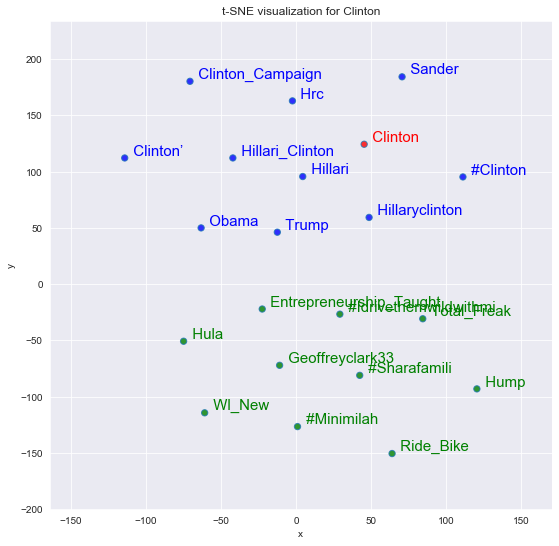

In [84]:
tsnescatterplot(w2v_model, 'clinton', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

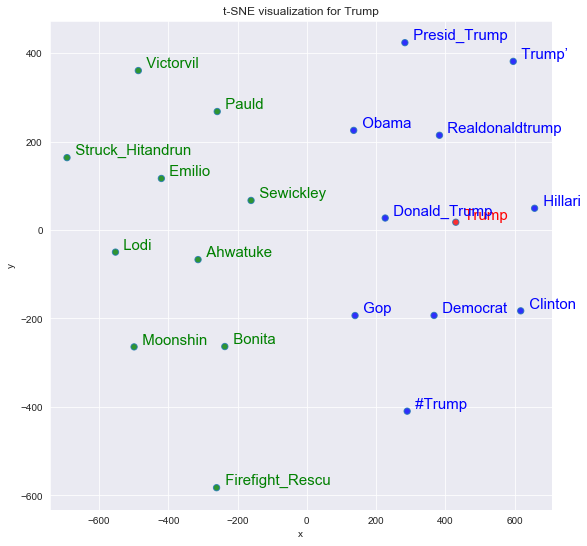

In [85]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])


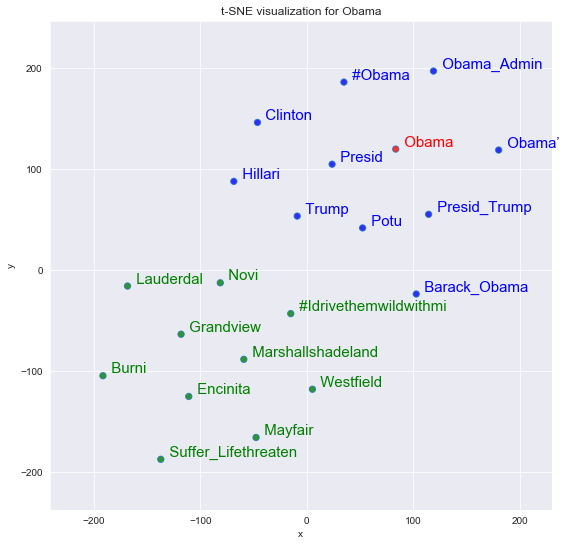

In [86]:
tsnescatterplot(w2v_model, 'obama', [i[0] for i in w2v_model.wv.most_similar(negative=["obama"])])

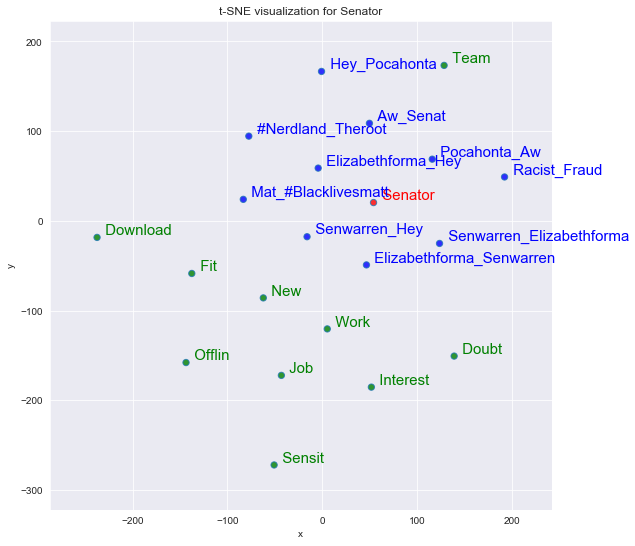

In [87]:
tsnescatterplot(w2v_model, 'senator', [i[0] for i in w2v_model.wv.most_similar(negative=["senator"])])

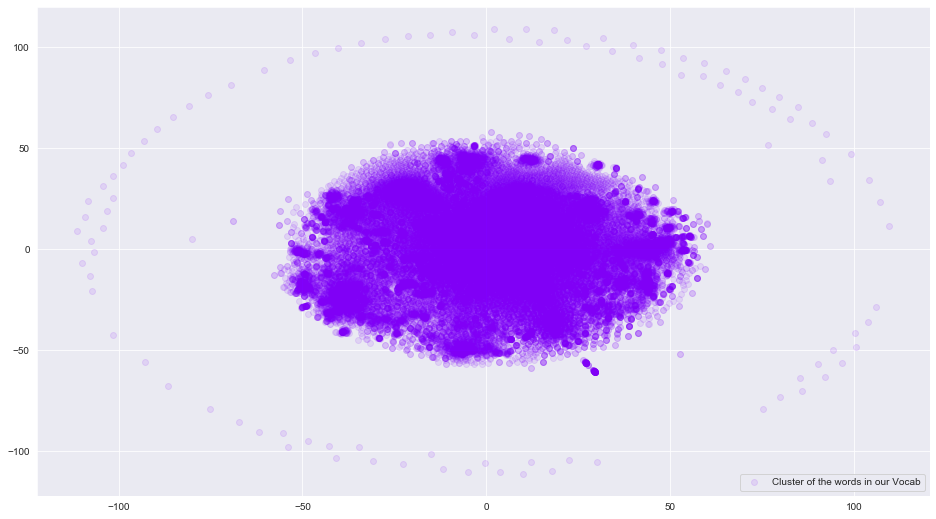

In [88]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
words_ak = []
embeddings_ak = []
for word in list(w2v_model.wv.vocab):
    embeddings_ak.append(w2v_model.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Cluster of the words in our Vocab', embeddings_ak_2d, a=0.1)

In [12]:
from textblob import TextBlob
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity
df_new['polarity'] = df_new['content'].apply(polarity)
df_new['subjectivity'] = df_new['content'].apply(subjectivity)

df_new.head()

df_new['YearMonth'] = pd.DatetimeIndex(df_new['publish_date']).year






L = ['trump', 'hillari','obama','donald','clinton','hillary','barrack']
pat = '|'.join(r"\b{}\b".format(x) for x in L)

df_new['tags'] = df_new['content'].str.extract('('+ pat + ')', expand=False, flags=re.I)


df_new1=df_new[(df_new['tags']=='trump') | (df_new['tags']=='donald')]
df_new2=df_new[(df_new['tags']=='hillari') | (df_new['tags']=='hillary')| (df_new['tags']=='clinton')]
df_new3=df_new[(df_new['tags']=='barrack') | (df_new['tags']=='obama')]




L = ['clinton', 'trump']
pat = '|'.join(r"\b{}\b".format(x) for x in L)

df_new['tags1'] = df_new['content'].str.findall(pat, flags=re.I).str.join(' ')
df_new.head()

df_new4=df_new[(df_new['tags1']=='clinton trump') | (df_new['tags1']=='trump clinton')]

df_new4.head(30)




C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Rajnish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1,polarity,subjectivity,YearMonth,tags,tags1
276,906000000000000000,10_GOP,top gop offici ed rollin say trump white hous ...,Unknown,English,9/21/2017 1:09,9/21/2017 1:09,1037,8410,181,...,910672210905456640,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/910672210905...,NaN,NaN,0.250000,0.250000,2017,trump,trump clinton
4859,749000000000000000,4EVER1937,clinton trump need win epic debat feldmik go...,Unknown,English,9/23/2016 15:25,9/23/2016 15:25,380,4515,1294,...,779340816485584896,http://twitter.com/4ever1937/statuses/77934081...,http://tinyurl.com/z6zzuxh,NaN,NaN,0.166667,0.500000,2016,clinton,clinton trump
6035,4036537452,4MYSQUAD,donald trump said want ban muslim hillari clin...,United States,English,10/22/2016 13:28,10/22/2016 13:28,4007,4708,1449,...,789820717990830085,http://twitter.com/4MySquad/statuses/789820717...,NaN,NaN,NaN,0.000000,0.000000,2016,donald,trump clinton
13383,1709314117,AANTIRACIST,21 21 white player trump ✅ 20 22 black player...,United States,English,10/6/2016 17:50,10/6/2016 17:50,997,1057,1763,...,784088507874615296,http://twitter.com/aantiracist/statuses/784088...,http://ble.ac/2dS2HUx,NaN,NaN,-0.083333,0.216667,2016,trump,trump clinton
13484,1709314117,AANTIRACIST,new #clinton ad featur cast ‘empire’ target #t...,United States,English,10/7/2016 0:04,10/7/2016 0:04,997,1060,1883,...,784182595374292993,http://twitter.com/aantiracist/statuses/784182...,https://youtu.be/x69l87ExRV0,NaN,NaN,0.136364,0.454545,2016,clinton,clinton trump
13978,1709314117,AANTIRACIST,trump 1993 suicid top clinton aid vinc foster ...,United States,English,5/24/2016 13:19,5/24/2016 13:19,686,570,1147,...,735097972745068544,http://twitter.com/aantiracist/statuses/735097...,https://twitter.com/thehill/status/73509124080...,http://hill.cm/oqTbiuP,NaN,0.500000,0.500000,2016,trump,trump clinton
14044,1709314117,AANTIRACIST,trump could beat clinton,United States,English,5/8/2016 13:38,5/8/2016 13:38,704,538,1053,...,729304462112657410,http://twitter.com/aantiracist/statuses/729304...,https://twitter.com/thehill/status/72929958988...,http://hill.cm/z2YAjLj,NaN,0.000000,0.000000,2016,trump,trump clinton
14108,1709314117,AANTIRACIST,trump collect 31 million campaign may clinton ...,United States,English,6/21/2016 12:54,6/21/2016 12:55,682,688,1284,...,745238535867817984,http://twitter.com/aantiracist/statuses/745238...,https://twitter.com/business/status/7452348732...,http://bloom.bg/28KjeqC,NaN,0.000000,0.000000,2016,trump,trump clinton
14450,1709314117,AANTIRACIST,theyr say want trump clinton isnt given work d...,United States,English,9/5/2016 16:15,9/5/2016 16:16,956,1025,1572,...,772830544107233280,http://twitter.com/aantiracist/statuses/772830...,NaN,NaN,NaN,0.000000,0.000000,2016,trump,trump clinton
15672,2534421182,ABIGAILSSILK,clinton trump brexit terror #2016in4word,United States,English,12/28/2016 17:09,12/28/2016 17:09,2193,1614,2064,...,814156358891294721,http://twitter.com/2534421182/statuses/8141563...,NaN,NaN,NaN,0.000000,0.000000,2016,clinton,clinton trump


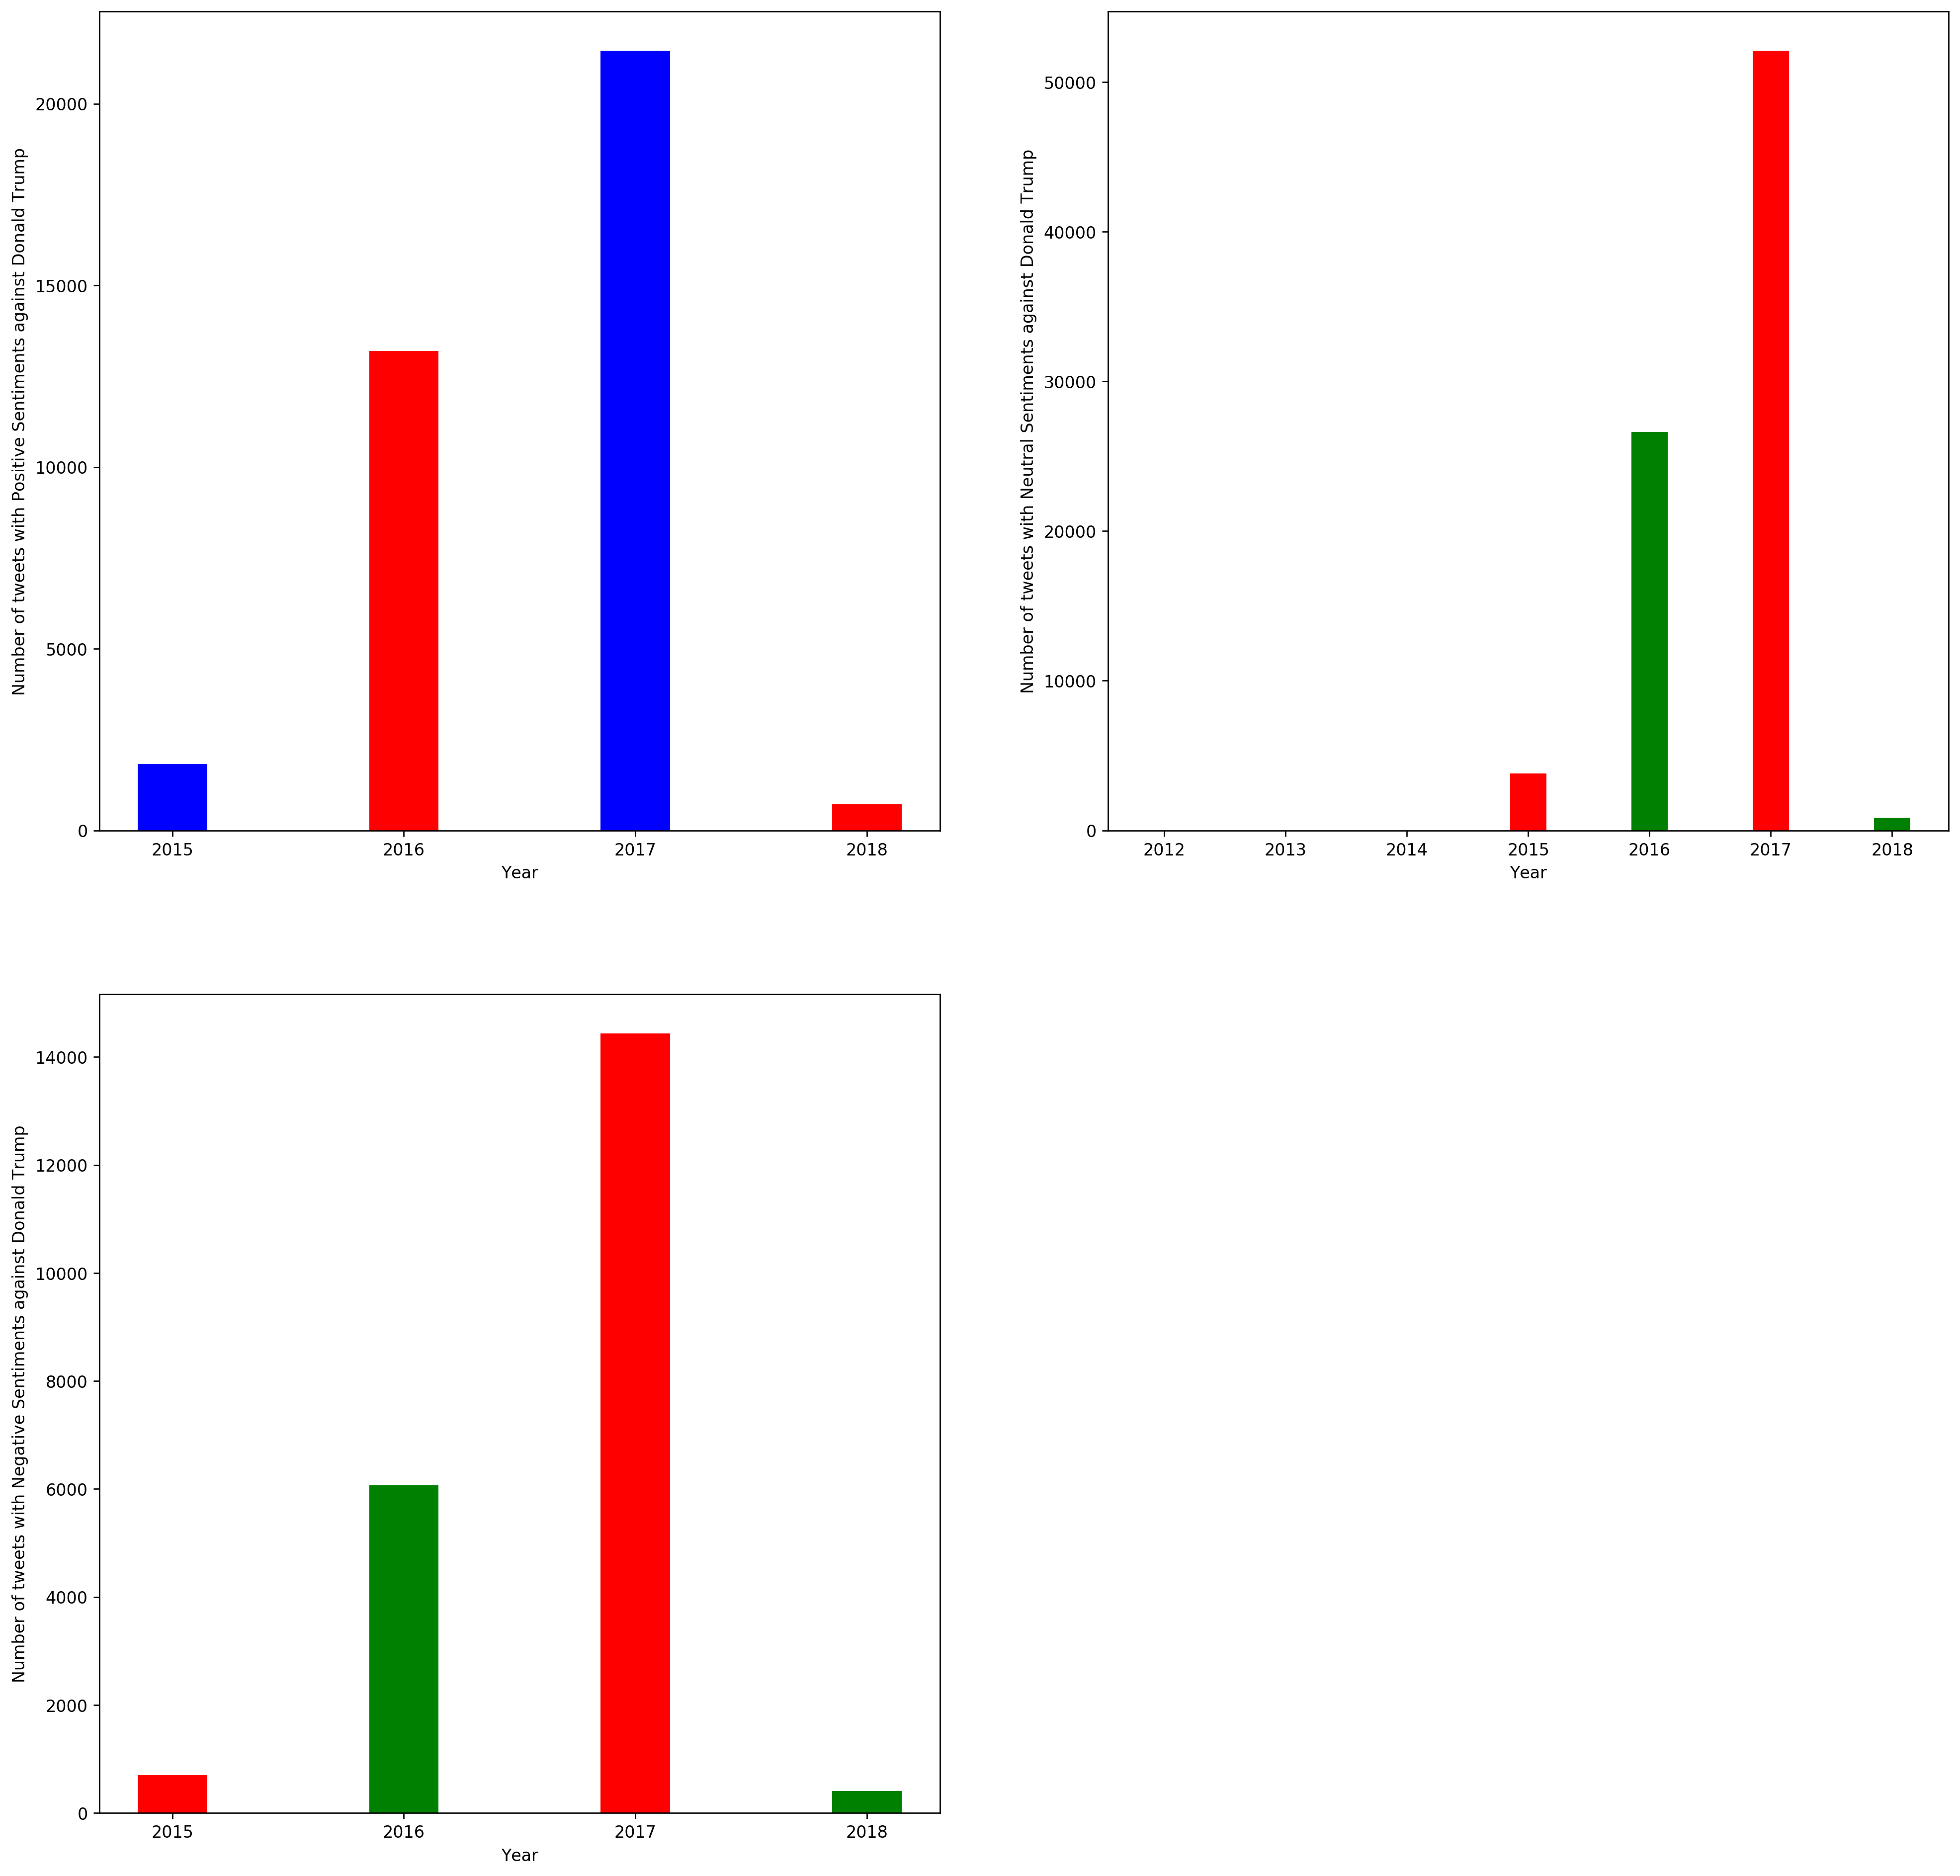

In [20]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=240, facecolor='w', edgecolor='k')
countpositivetrump=df_new1[df_new1['polarity'] > 0].groupby(['YearMonth']).count().reset_index()
countneutraltrump=df_new1[df_new1['polarity'] == 0].groupby(['YearMonth']).count().reset_index()
countnegativetrump=df_new1[df_new1['polarity'] < 0].groupby(['YearMonth']).count().reset_index()
w = 0.3
ax1 = plt.subplot(221)
ax1.bar(countpositivetrump['YearMonth'], countpositivetrump['polarity'], width=w, color='br', align='center')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Positive Sentiments against Donald Trump")
plt1.xlabel("Year")
ax2 = plt.subplot(222)
ax2.bar(countneutraltrump['YearMonth'], countneutraltrump['polarity'], width=w, color='gr', align='center')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt2.ylabel("Number of tweets with Neutral Sentiments against Donald Trump")
plt2.xlabel("Year")
ax3 = plt.subplot(223)
ax3.bar(countnegativetrump['YearMonth'], countnegativetrump['polarity'], width=w, color='rg', align='center')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Negative Sentiments against Donald Trump")
plt1.xlabel("Year")
plt.show()


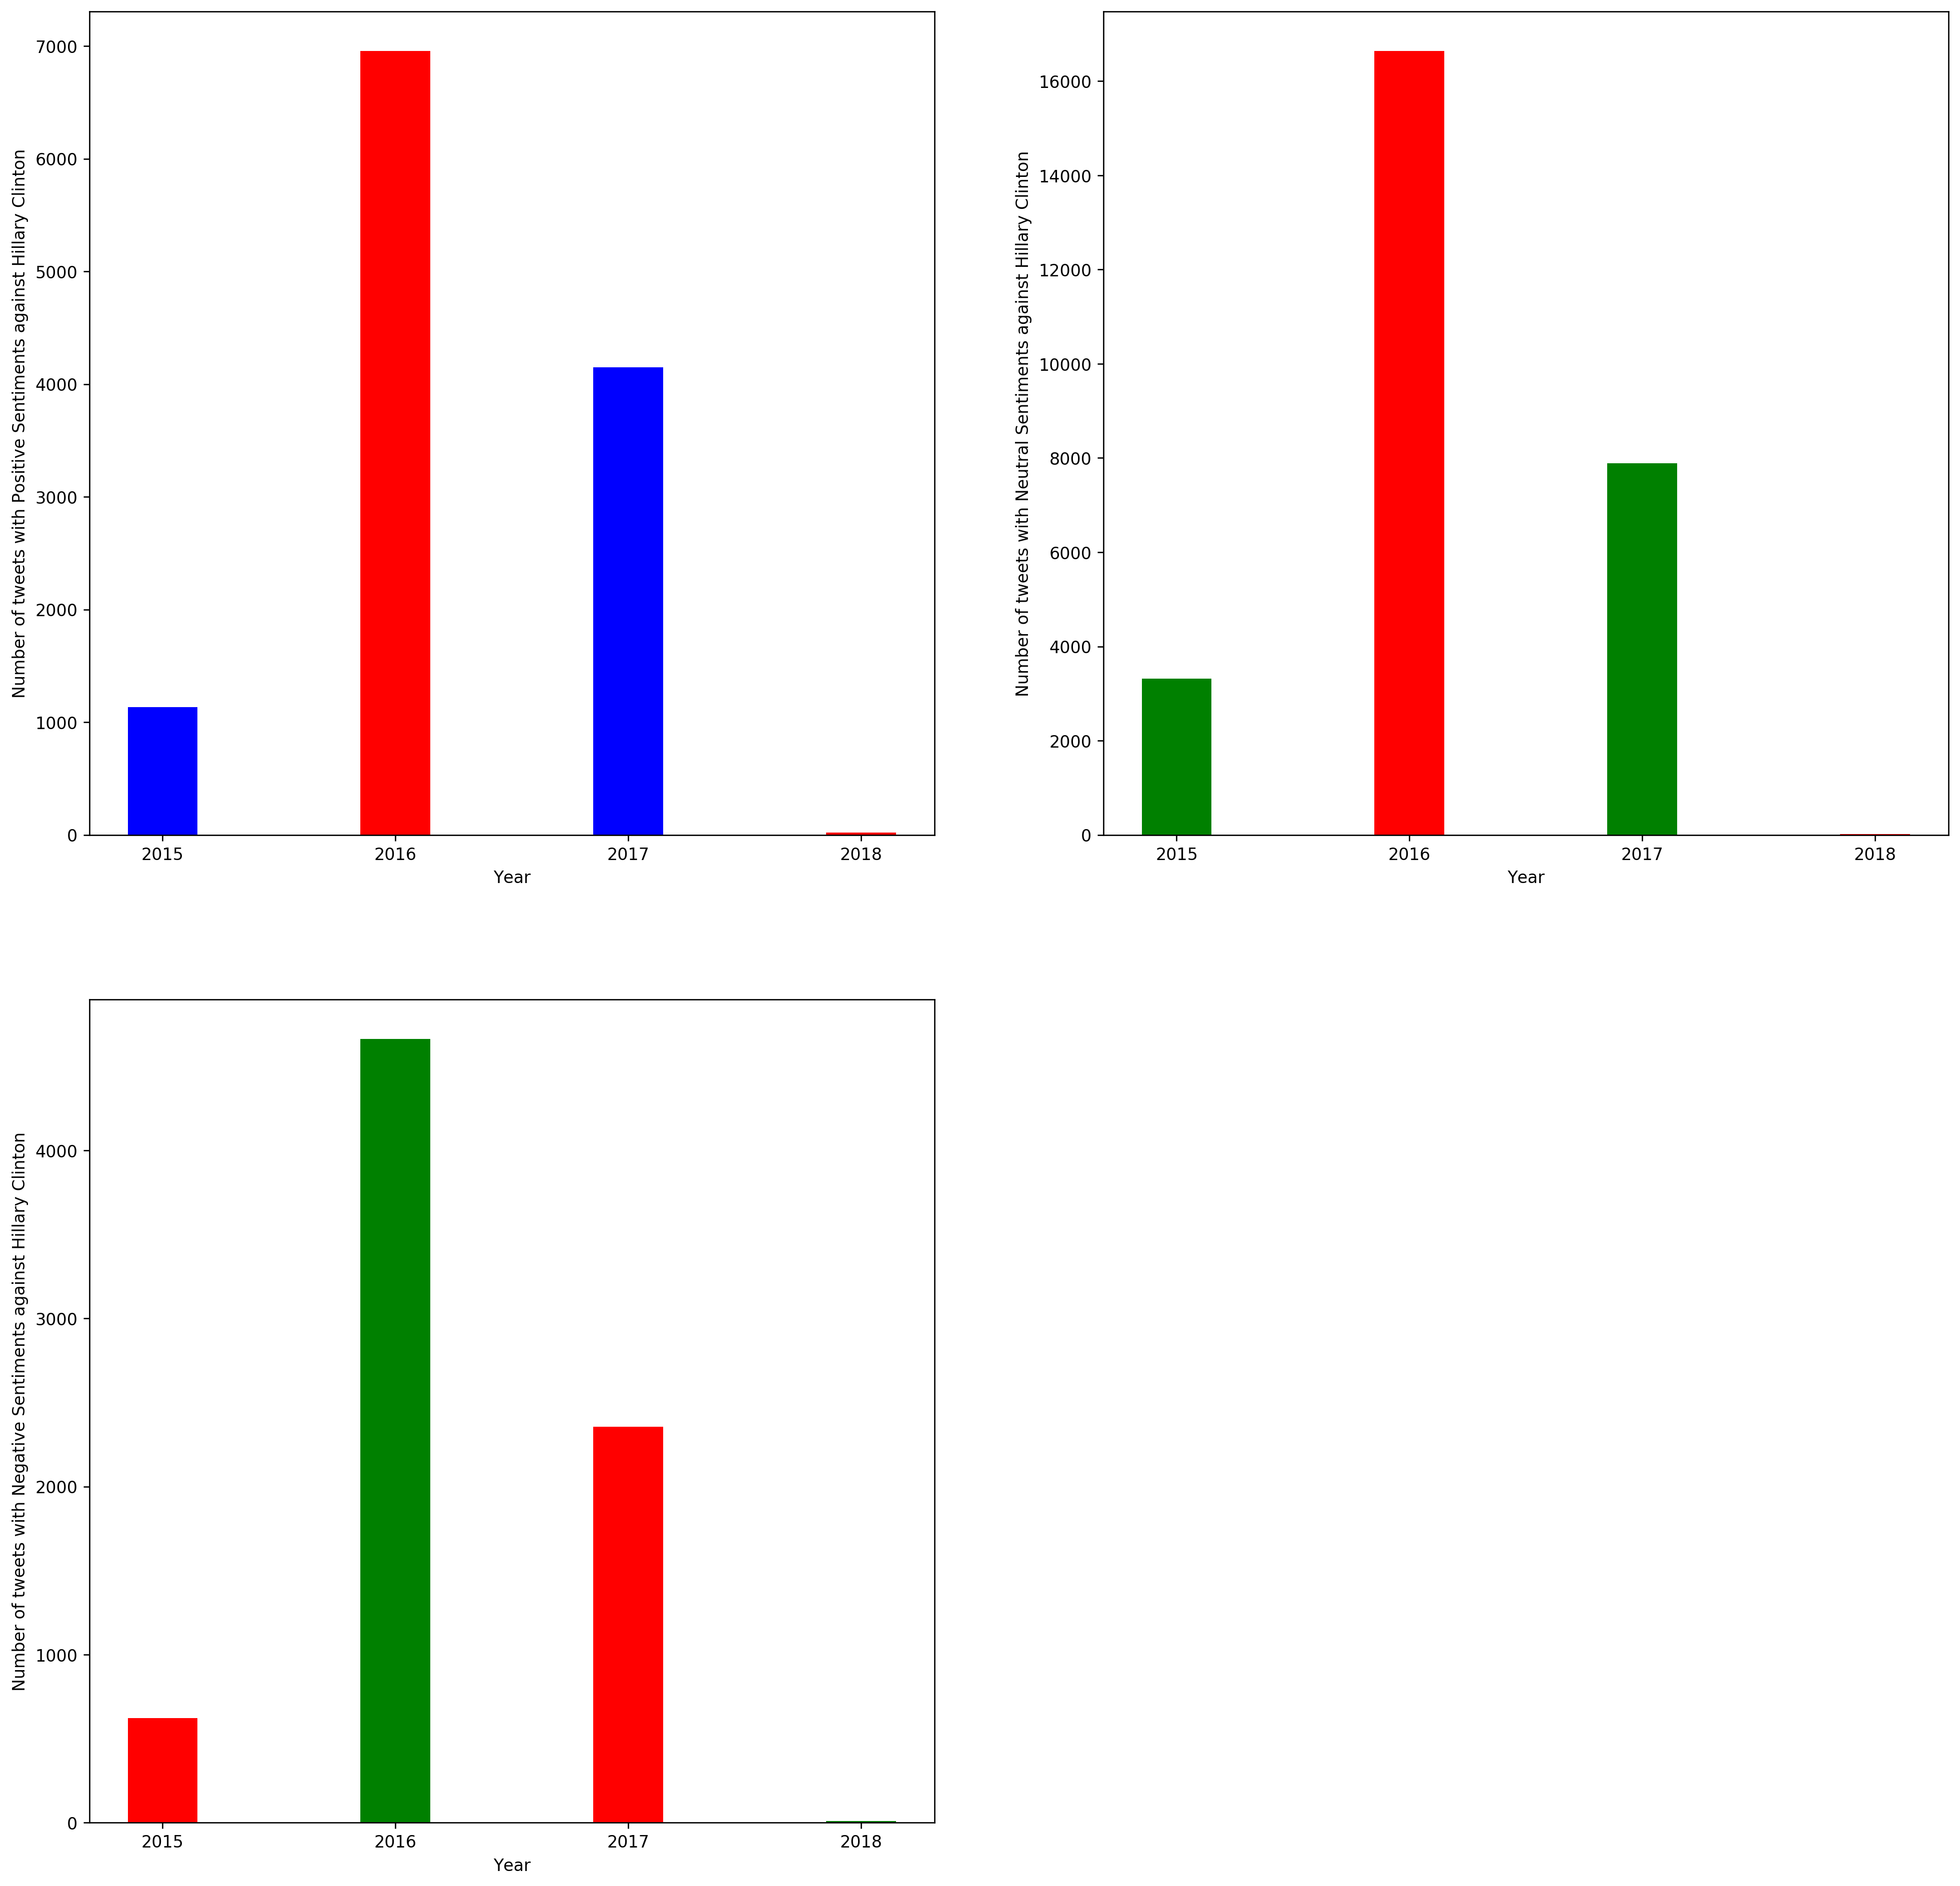

In [21]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=240, facecolor='w', edgecolor='k')
countpositivehillary=df_new2[df_new2['polarity'] > 0].groupby(['YearMonth']).count().reset_index()
countneutralhillary=df_new2[df_new2['polarity'] == 0].groupby(['YearMonth']).count().reset_index()
countnegativehillary=df_new2[df_new2['polarity'] < 0].groupby(['YearMonth']).count().reset_index()
w = 0.3
ax1 = plt.subplot(221)
ax1.bar(countpositivehillary['YearMonth'], countpositivehillary['polarity'], width=w, color='br', align='center')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Positive Sentiments against Hillary Clinton")
plt1.xlabel("Year")
ax2 = plt.subplot(222)
ax2.bar(countneutralhillary['YearMonth'], countneutralhillary['polarity'], width=w, color='gr', align='center')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt2.ylabel("Number of tweets with Neutral Sentiments against Hillary Clinton")
plt2.xlabel("Year")
ax3 = plt.subplot(223)
ax3.bar(countnegativehillary['YearMonth'], countnegativehillary['polarity'], width=w, color='rg', align='center')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Negative Sentiments against Hillary Clinton")
plt1.xlabel("Year")
plt.show()

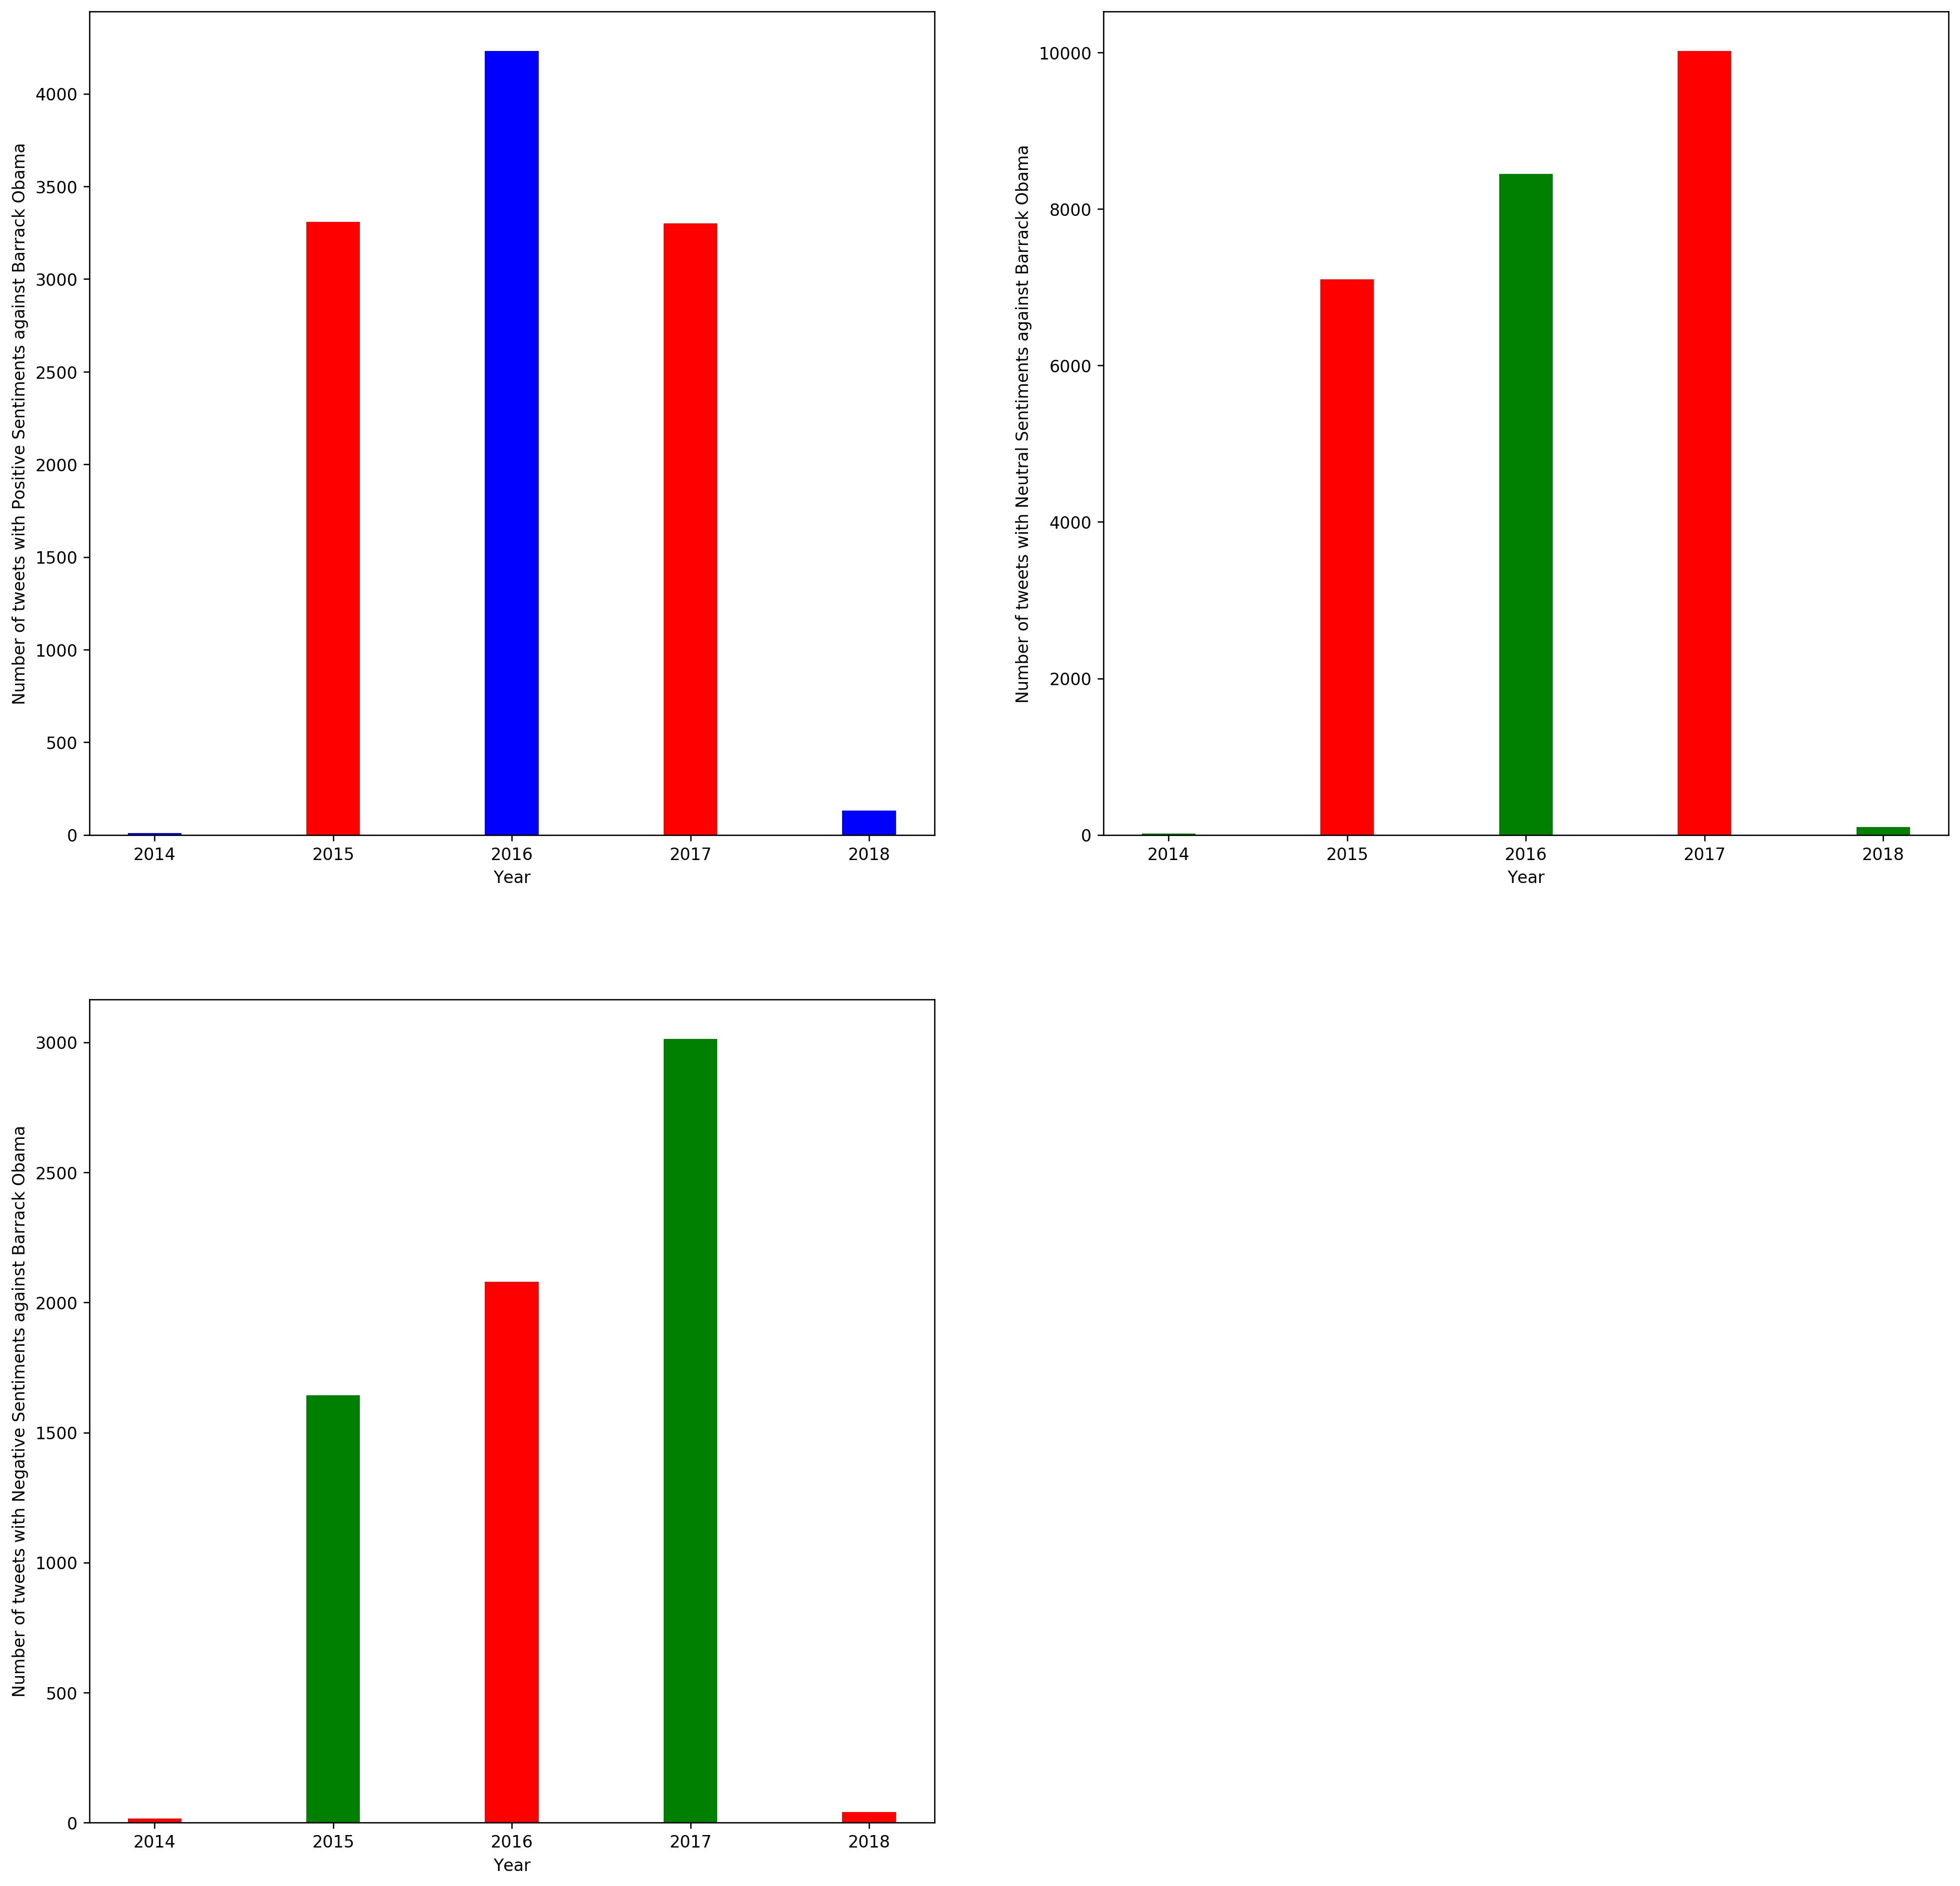

In [22]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=240, facecolor='w', edgecolor='k')
countpositiveobama=df_new3[df_new3['polarity'] > 0].groupby(['YearMonth']).count().reset_index()
countneutralobama=df_new3[df_new3['polarity'] == 0].groupby(['YearMonth']).count().reset_index()
countnegativeobama=df_new3[df_new3['polarity'] < 0].groupby(['YearMonth']).count().reset_index()
w = 0.3
ax1 = plt.subplot(221)
ax1.bar(countpositiveobama['YearMonth'], countpositiveobama['polarity'], width=w, color='br', align='center')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Positive Sentiments against Barrack Obama")
plt1.xlabel("Year")
ax2 = plt.subplot(222)
ax2.bar(countneutralobama['YearMonth'], countneutralobama['polarity'], width=w, color='gr', align='center')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt2.ylabel("Number of tweets with Neutral Sentiments against Barrack Obama")
plt2.xlabel("Year")
ax3 = plt.subplot(223)
ax3.bar(countnegativeobama['YearMonth'], countnegativeobama['polarity'], width=w, color='rg', align='center')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Negative Sentiments against Barrack Obama")
plt1.xlabel("Year")
plt.show()


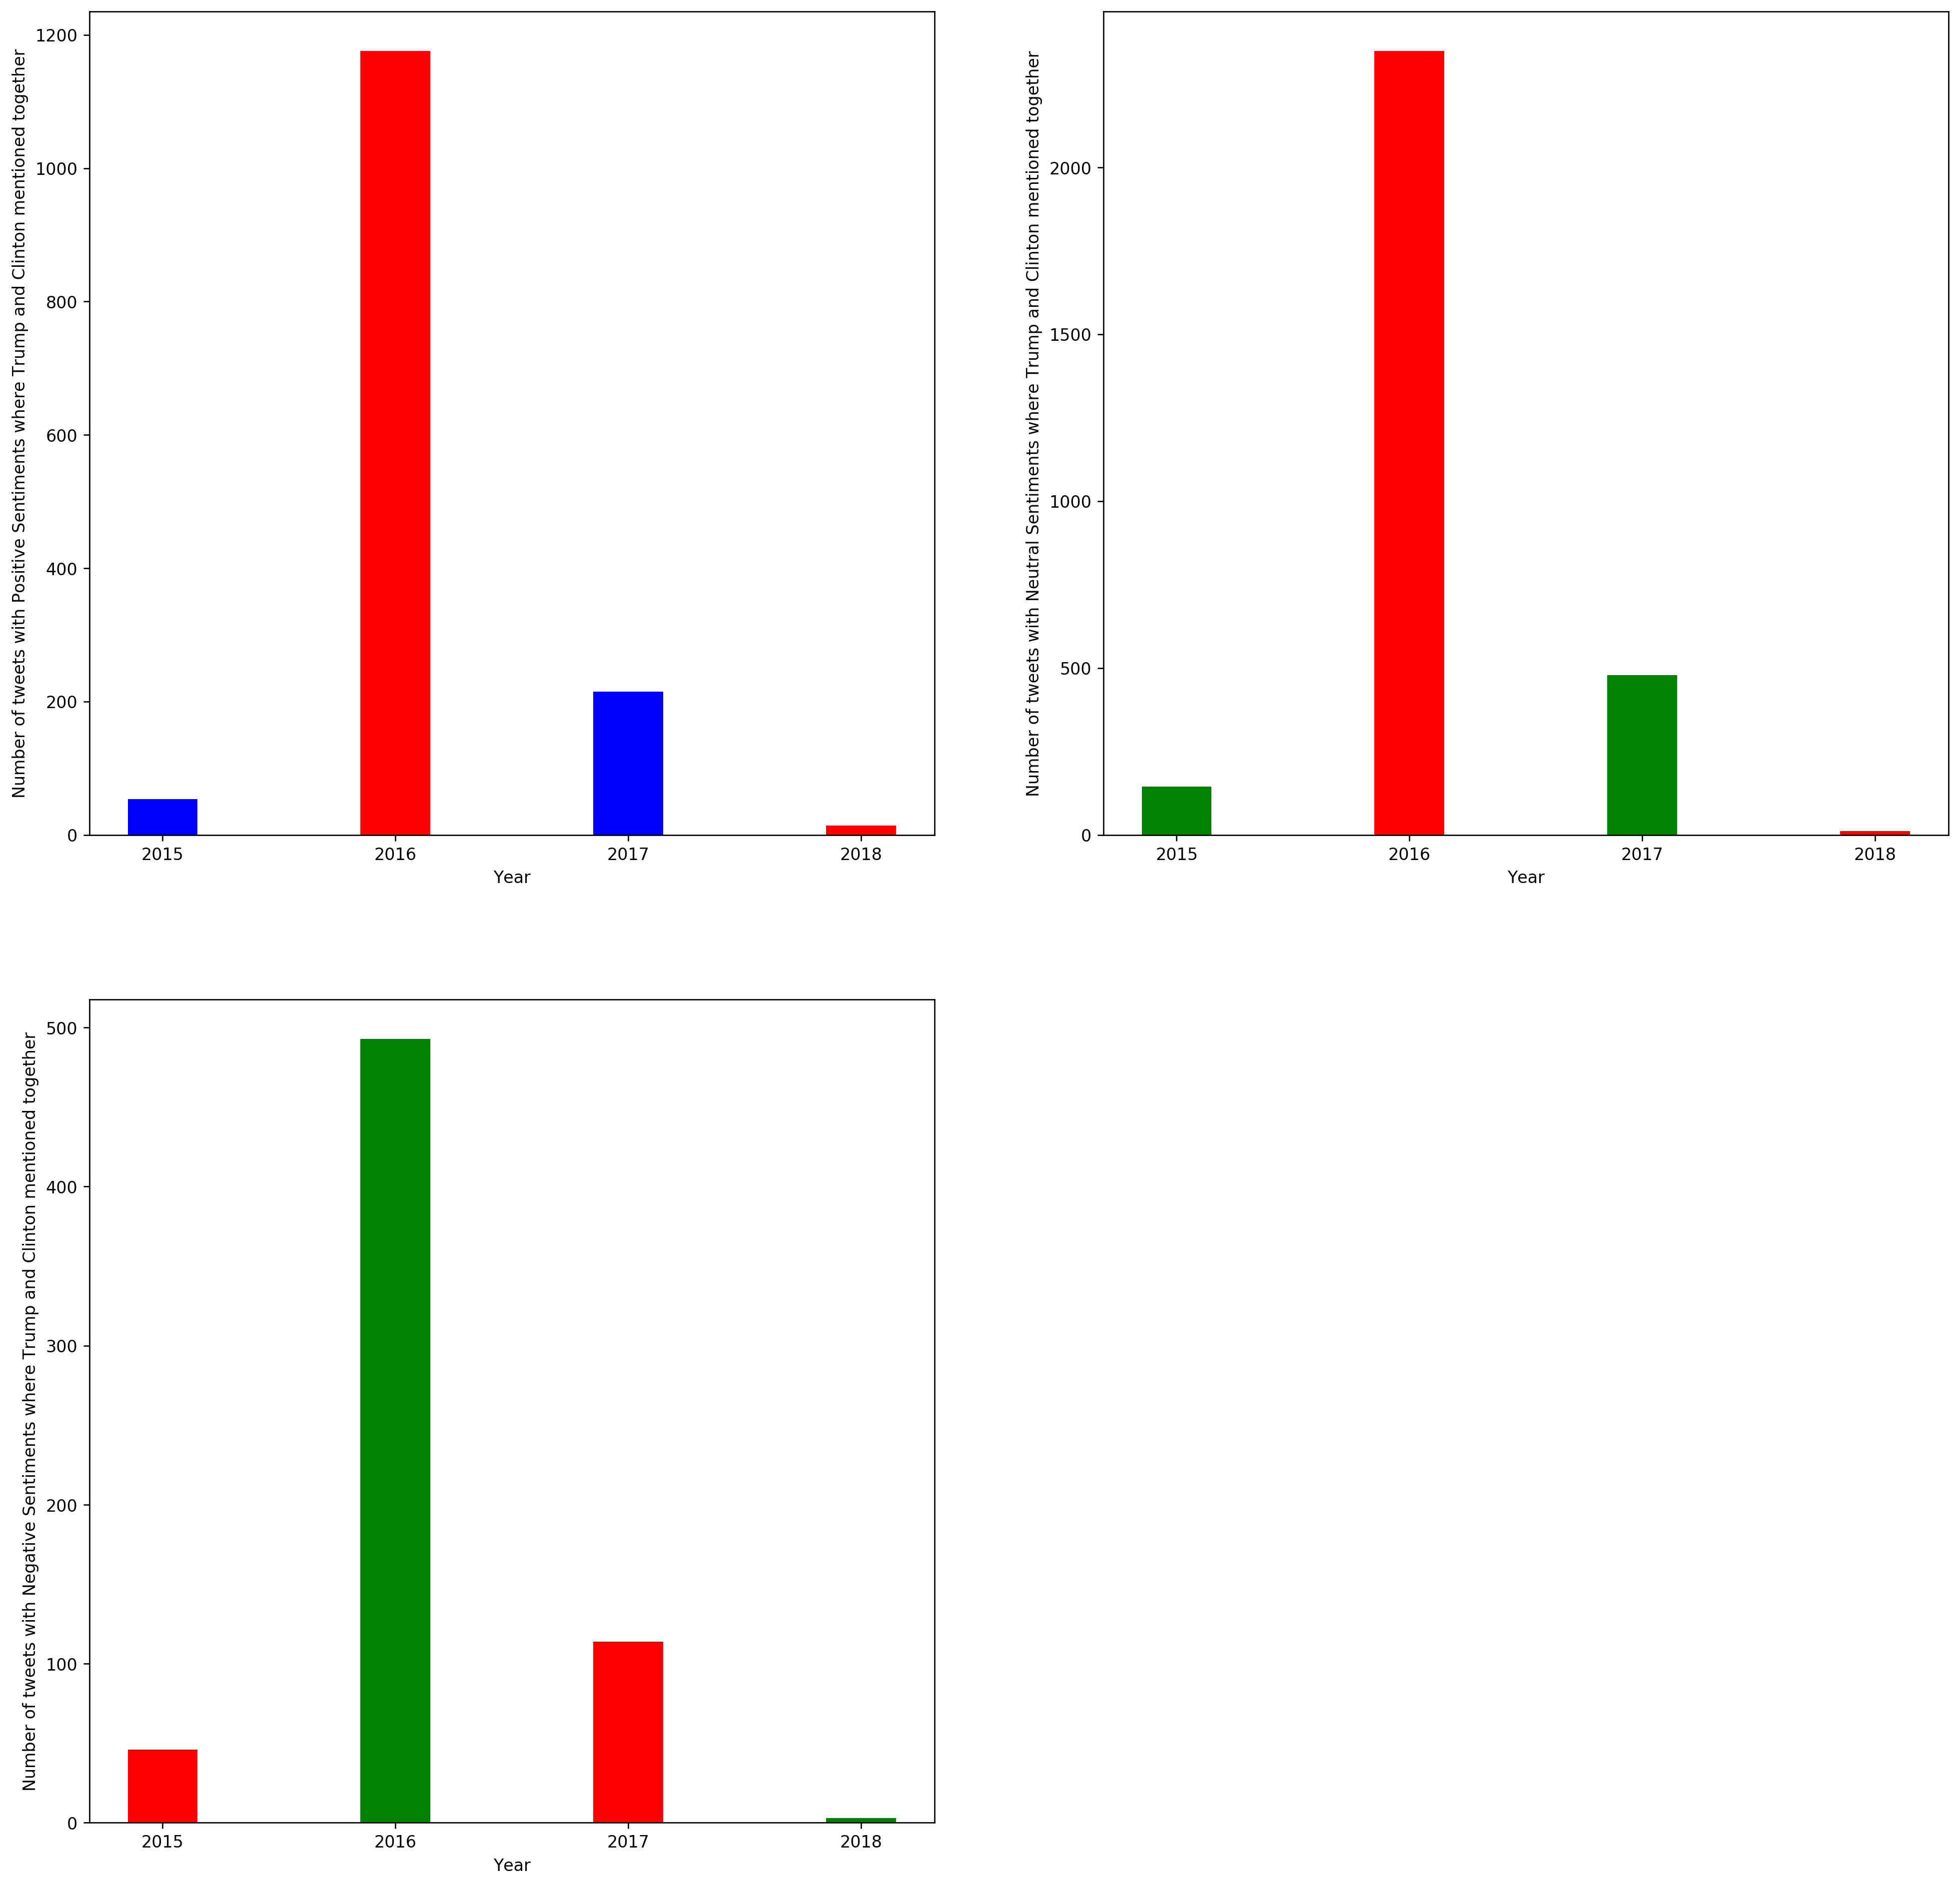

In [23]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=240, facecolor='w', edgecolor='k')
countpositiveclintru=df_new4[df_new4['polarity'] > 0].groupby(['YearMonth']).count().reset_index()
countneutralclintru=df_new4[df_new4['polarity'] == 0].groupby(['YearMonth']).count().reset_index()
countnegativeclintru=df_new4[df_new4['polarity'] < 0].groupby(['YearMonth']).count().reset_index()
w = 0.3
ax1 = plt.subplot(221)
ax1.bar(countpositiveclintru['YearMonth'], countpositiveclintru['polarity'], width=w, color='br', align='center')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Positive Sentiments where Trump and Clinton mentioned together")
plt1.xlabel("Year")
ax2 = plt.subplot(222)
ax2.bar(countneutralclintru['YearMonth'], countneutralclintru['polarity'], width=w, color='gr', align='center')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt2.ylabel("Number of tweets with Neutral Sentiments where Trump and Clinton mentioned together")
plt2.xlabel("Year")
ax3 = plt.subplot(223)
ax3.bar(countnegativeclintru['YearMonth'], countnegativeclintru['polarity'], width=w, color='rg', align='center')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt1.ylabel("Number of tweets with Negative Sentiments where Trump and Clinton mentioned together")
plt1.xlabel("Year")
plt.show()